# Data

## 1: Prep + compute Bemis–Murcko scaffolds (with debug + on-disk audit)

This cell:

Loads your raw CSV

Validates SMILES

Keeps rows with at least one known label

Computes the Murcko scaffold for each molecule

Saves an audit CSV and a short log so we can trace decisions later

In [ ]:
import os, sys, json, math, time
from pathlib import Path
import pandas as pd
import numpy as np

# RDKit imports
from rdkit import RDLogger, Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Silence RDKit warnings for cleaner logs
RDLogger.DisableLog('rdApp.*')

# ---------- Paths ----------
ROOT = Path("tox21_chemberta_v4/data")
RAW_CSV = ROOT / "tox21.csv"

SPLIT_DIR = ROOT / "splits"
LOG_DIR = ROOT / "logs"
SPLIT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

SCAFFOLD_CSV = SPLIT_DIR / "scaffolds.csv"
LOG_FILE = LOG_DIR / "scaffold_prep.log"

# ---------- Helpers ----------
def now():
    return time.strftime("%Y-%m-%d %H:%M:%S")

def is_valid_smiles(sm: str) -> bool:
    try:
        m = Chem.MolFromSmiles(sm)
        return m is not None
    except Exception:
        return False

def to_scaffold(sm: str) -> str:
    m = Chem.MolFromSmiles(sm)
    if m is None:
        return ""
    scaf = MurckoScaffold.GetScaffoldForMol(m)
    return Chem.MolToSmiles(scaf, isomericSmiles=True) if scaf is not None else ""

# ---------- Load ----------
assert RAW_CSV.exists(), f"Raw CSV not found at: {RAW_CSV}"
df = pd.read_csv(RAW_CSV)
print(f"[{now()}] Loaded CSV: {RAW_CSV} with shape {df.shape}")

# Expect 14 columns: 12 labels + mol_id + smiles (but we are flexible)
assert "smiles" in df.columns, "Column 'smiles' not found in the CSV."

# Infer label columns as the first 12, per your schema
label_cols = list(df.columns[:12])
print(f"[{now()}] Inferred label columns (12): {label_cols}")

# ---------- Filter rows ----------
# Keep rows with valid SMILES and at least one known label (not NaN)
df["smiles"] = df["smiles"].astype(str)
is_valid = df["smiles"].apply(is_valid_smiles)
labels_known = df[label_cols].notna().any(axis=1)

before_n = len(df)
df = df.loc[is_valid & labels_known].copy().reset_index(drop=True)
after_n = len(df)
dropped_invalid = before_n - after_n

print(f"[{now()}] Kept rows with valid SMILES and >=1 known label.")
print(f"            Before: {before_n} rows")
print(f"            After : {after_n} rows")
print(f"            Dropped (invalid/no-label): {dropped_invalid} rows")

# ---------- Compute scaffolds ----------
print(f"[{now()}] Computing Bemis–Murcko scaffolds (this may take a moment)...")
df["scaffold"] = df["smiles"].apply(to_scaffold)

# Some molecules may have empty scaffolds (rare); mark them explicitly
empty_scaf = (df["scaffold"] == "").sum()
print(f"[{now()}] Empty scaffolds: {empty_scaf} (will be treated as their own singleton group)")

# ---------- Summary / debug ----------
unique_scaffolds = df["scaffold"].nunique(dropna=False)
counts = df["scaffold"].value_counts(dropna=False)

print(f"[{now()}] Unique scaffolds: {unique_scaffolds}")
print(f"[{now()}] Top 10 scaffold sizes:")
print(counts.head(10))

# Show a small preview to sanity-check alignment
preview_cols = ["smiles", "scaffold"] + label_cols[:3]  # peek at first 3 labels
print(f"\n[{now()}] Preview (first 5 rows):")
print(df[preview_cols].head(5).to_string(index=False))

# ---------- Save audit artifacts ----------
df_out = df[["smiles", "scaffold"]].copy()
# Add a quick count of how many labels are known per row (for auditing)
df_out["known_label_count"] = df[label_cols].notna().sum(axis=1).astype(int)
df_out.to_csv(SCAFFOLD_CSV, index=False)

with open(LOG_FILE, "a", encoding="utf-8") as f:
    f.write(f"[{now()}] Scaffold prep\n")
    f.write(f"  Input file   : {RAW_CSV}\n")
    f.write(f"  Rows before  : {before_n}\n")
    f.write(f"  Rows after   : {after_n}\n")
    f.write(f"  Dropped      : {dropped_invalid}\n")
    f.write(f"  Unique scafs : {unique_scaffolds}\n")
    f.write(f"  Empty scafs  : {empty_scaf}\n")
    f.write(f"  Audit CSV    : {SCAFFOLD_CSV}\n\n")

print(f"\n[{now()}] Wrote scaffold audit CSV → {SCAFFOLD_CSV}")
print(f"[{now()}] Logged summary           → {LOG_FILE}")


[2025-09-01 11:49:57] Loaded CSV: tox21_chemberta_v4\data\tox21.csv with shape (7831, 14)
[2025-09-01 11:49:57] Inferred label columns (12): ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
[2025-09-01 11:49:58] Kept rows with valid SMILES and >=1 known label.
            Before: 7831 rows
            After : 7831 rows
            Dropped (invalid/no-label): 0 rows
[2025-09-01 11:49:58] Computing Bemis–Murcko scaffolds (this may take a moment)...
[2025-09-01 11:49:59] Empty scaffolds: 1781 (will be treated as their own singleton group)
[2025-09-01 11:49:59] Unique scaffolds: 2405
[2025-09-01 11:49:59] Top 10 scaffold sizes:
scaffold
                       1781
c1ccccc1               1474
c1ccncc1                 89
c1ccc(Cc2ccccc2)cc1      83
c1ccc2ccccc2c1           69
C1CCCCC1                 63
c1c[nH+]c[nH]1           48
c1ccc(Oc2ccccc2)cc1      45
c1ccc(-c2ccccc2)cc1      40
C1=CCCCC1       

## 2: Deterministic Scaffold Split (80/10/10), with robust handling of empty scaffolds

This cell:

Groups rows by scaffold (but makes empty scaffold groups singleton per row)

Greedily assigns groups to train/val/test to hit 80/10/10

Verifies no leakage (no scaffold appears in multiple splits)

Prints counts and label prevalence per split

Saves:

tox21_chemberta_v4/data/splits/splits.json

tox21_chemberta_v4/data/splits/split_membership.csv

Appends to tox21_chemberta_v4/data/logs/scaffold_prep.log

In [ ]:
import json, time
from collections import defaultdict
from pathlib import Path
import numpy as np
import pandas as pd
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')

# Reuse df, label_cols from previous cell; if not present, reload and rebuild scaffolds
try:
    df
    label_cols
except NameError:
    ROOT = Path("tox21_chemberta_v4/data")
    df = pd.read_csv(ROOT/"tox21.csv")
    label_cols = list(df.columns[:12])
    from rdkit import Chem
    from rdkit.Chem.Scaffolds import MurckoScaffold
    def to_scaffold(sm: str) -> str:
        m = Chem.MolFromSmiles(sm)
        if m is None:
            return ""
        scaf = MurckoScaffold.GetScaffoldForMol(m)
        return Chem.MolToSmiles(scaf, isomericSmiles=True) if scaf is not None else ""
    df["smiles"] = df["smiles"].astype(str)
    df["scaffold"] = df["smiles"].apply(to_scaffold)

ROOT = Path("tox21_chemberta_v4/data")
SPLIT_DIR = ROOT / "splits"
LOG_DIR = ROOT / "logs"
SPLIT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

SPLITS_JSON = SPLIT_DIR / "splits.json"
MEMBERSHIP_CSV = SPLIT_DIR / "split_membership.csv"
LOG_FILE = LOG_DIR / "scaffold_prep.log"

N = len(df)
target = {"train": 0.80, "val": 0.10, "test": 0.10}
target_counts = {k: int(round(v * N)) for k, v in target.items()}

print(f"[INFO] Total rows: {N}")
print(f"[INFO] Target counts: {target_counts}")

# --- Build groups: use scaffold; for empty scaffold '', make a unique pseudo-scaffold per row ---
groups = defaultdict(list)
for i, scaf in enumerate(df["scaffold"].astype(str).values):
    key = scaf if scaf.strip() != "" else f"EMPTY_{i}"  # singleton group for empty scaffold
    groups[key].append(i)

# Sanity check groups
num_groups = len(groups)
sizes_preview = sorted([(k, len(v)) for k, v in groups.items()], key=lambda kv: -kv[1])[:10]
print(f"[DEBUG] Number of groups: {num_groups}")
print(f"[DEBUG] Largest 10 groups (key, size): {sizes_preview}")

# Sort groups by descending size, then by key for determinism
ordered_keys = sorted(groups.keys(), key=lambda k: (-len(groups[k]), k))

# --- Greedy assignment to train/val/test by filling the bin with largest deficit to target ---
split_bins = {"train": [], "val": [], "test": []}
bin_counts = {"train": 0, "val": 0, "test": 0}

def pick_bin():
    # choose the split that is furthest below its target
    deficits = {k: target_counts[k] - bin_counts[k] for k in bin_counts}
    # tie-breaker: train > val > test for stability
    order = ["train", "val", "test"]
    # pick the key with max(deficit), with tie-breaking
    max_def = max(deficits.values())
    candidates = [k for k, v in deficits.items() if v == max_def]
    for k in order:
        if k in candidates:
            return k

for gk in ordered_keys:
    idxs = groups[gk]
    if not hasattr(idxs, "__iter__"):
        raise TypeError(f"Group '{gk}' indices are not iterable: {type(idxs)}")
    b = pick_bin()
    split_bins[b].extend(idxs)
    bin_counts[b] += len(idxs)

# --- Verify no scaffold leakage ---
assigned = {}
leakage = []
for split, idxs in split_bins.items():
    for i in idxs:
        scaf = df.at[i, "scaffold"]
        key = scaf if scaf.strip() != "" else f"EMPTY_{i}"
        if key in assigned and assigned[key] != split:
            leakage.append((key, assigned[key], split))
        assigned[key] = split

assert not leakage, f"Scaffold leakage detected: {leakage[:5]}"

# --- Finalize indices (sorted) ---
train_idx = sorted(split_bins["train"])
val_idx   = sorted(split_bins["val"])
test_idx  = sorted(split_bins["test"])

print(f"[INFO] Final split sizes → train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")
print(f"[INFO] Sum check: {len(train_idx) + len(val_idx) + len(test_idx)} == {N}")

# --- Quick label prevalence debug per split (ignoring NaNs) ---
def prevalence(y_series):
    known = y_series.dropna()
    if len(known) == 0:
        return np.nan
    return float((known == 1).mean())

prevalence_table = []
for split_name, idxs in [("train", train_idx), ("val", val_idx), ("test", test_idx)]:
    row = {"split": split_name, "n": len(idxs)}
    for lbl in label_cols:
        row[lbl] = round(prevalence(df.loc[idxs, lbl]), 3)
    prevalence_table.append(row)

prev_df = pd.DataFrame(prevalence_table)
print("\n[INFO] Label prevalence (positive rate among known labels) by split:")
print(prev_df.to_string(index=False))

# --- Save splits.json and membership CSV ---
splits = {"train": train_idx, "val": val_idx, "test": test_idx}
with open(SPLITS_JSON, "w") as f:
    json.dump(splits, f, indent=2)

mship = []
for sname, idxs in [("train", train_idx), ("val", val_idx), ("test", test_idx)]:
    for i in idxs:
        mship.append({
            "row_id": int(i),
            "split": sname,
            "scaffold_key": (df.at[i, "scaffold"] if df.at[i, "scaffold"].strip() != "" else f"EMPTY_{i}"),
            "scaffold": df.at[i, "scaffold"],
            "smiles": df.at[i, "smiles"]
        })
mship_df = pd.DataFrame(mship)
mship_df.to_csv(MEMBERSHIP_CSV, index=False)

with open(LOG_FILE, "a", encoding="utf-8") as f:
    f.write(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Scaffold split\n")
    f.write(f"  Total rows : {N}\n")
    f.write(f"  Targets    : {target_counts}\n")
    f.write(f"  Sizes      : train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}\n")
    f.write(f"  Splits JSON: {SPLITS_JSON}\n")
    f.write(f"  Membership : {MEMBERSHIP_CSV}\n\n")

print(f"\n[OK] Saved splits → {SPLITS_JSON}")
print(f"[OK] Saved membership CSV → {MEMBERSHIP_CSV}")


[INFO] Total rows: 7831
[INFO] Target counts: {'train': 6265, 'val': 783, 'test': 783}
[DEBUG] Number of groups: 4185
[DEBUG] Largest 10 groups (key, size): [('c1ccccc1', 1474), ('c1ccncc1', 89), ('c1ccc(Cc2ccccc2)cc1', 83), ('c1ccc2ccccc2c1', 69), ('C1CCCCC1', 63), ('c1c[nH+]c[nH]1', 48), ('c1ccc(Oc2ccccc2)cc1', 45), ('c1ccc(-c2ccccc2)cc1', 40), ('C1=CCCCC1', 38), ('c1ccc2ncccc2c1', 35)]
[INFO] Final split sizes → train: 6265, val: 783, test: 783
[INFO] Sum check: 7831 == 7831

[INFO] Label prevalence (positive rate among known labels) by split:
split    n  NR-AR  NR-AR-LBD  NR-AhR  NR-Aromatase  NR-ER  NR-ER-LBD  NR-PPAR-gamma  SR-ARE  SR-ATAD5  SR-HSE  SR-MMP  SR-p53
train 6265  0.045      0.039   0.120         0.050  0.133      0.054          0.027   0.156     0.037   0.056   0.161   0.057
  val  783  0.030      0.021   0.105         0.064  0.111      0.035          0.036   0.197     0.036   0.053   0.146   0.078
 test  783  0.036      0.020   0.103         0.052  0.102      0.035 

## 3: Encode labels (NaN→-1), save y.npy, y_mask.npy, X_smiles.txt, and meta.jsonEncode labels (NaN→-1), save y.npy, y_mask.npy, X_smiles.txt, and meta.json

In [8]:
import json, time
from pathlib import Path
import numpy as np
import pandas as pd

def now():
    import time
    return time.strftime("%Y-%m-%d %H:%M:%S")

ROOT = Path("tox21_chemberta_v4/data")
SPLIT_DIR = ROOT / "splits"
LOG_DIR = ROOT / "logs"
SPLIT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

RAW_CSV = ROOT / "tox21.csv"
SPLITS_JSON = SPLIT_DIR / "splits.json"

Y_NPY = ROOT / "y.npy"
Y_MASK_NPY = ROOT / "y_mask.npy"
SMILES_TXT = ROOT / "X_smiles.txt"
LABELS_TXT = ROOT / "label_names.txt"
META_JSON = ROOT / "meta.json"
LOG_FILE = LOG_DIR / "dataset_core.log"

# --- Load df & splits deterministically ---
try:
    df
    label_cols
except NameError:
    df = pd.read_csv(RAW_CSV)
    label_cols = list(df.columns[:12])

with open(SPLITS_JSON, "r") as f:
    splits = json.load(f)

# --- Sanity checks ---
assert all(lbl in df.columns for lbl in label_cols), "Some label columns are missing from the CSV."
assert "smiles" in df.columns, "Column 'smiles' is required."

N = len(df)
L = len(label_cols)

# --- Build label matrix and mask ---
y_df = df[label_cols].copy()
y_mask = (~y_df.isna()).astype(np.int8).values  # 1 if known, 0 if missing
y = y_df.fillna(-1).astype("float32").values    # encode missing as -1 for loss masking later

# --- Save labels & mask ---
np.save(Y_NPY, y)
np.save(Y_MASK_NPY, y_mask)
with open(LABELS_TXT, "w", encoding="utf-8") as f:
    f.write("\n".join(label_cols))

# --- Save SMILES (aligned to df row order) ---
df["smiles"] = df["smiles"].astype(str)
SMILES_TXT.write_text("\n".join(df["smiles"].tolist()), encoding="utf-8")

# --- Build simple stats for debug/traceability ---
def pos_rate(series):
    known = series.dropna()
    return float((known == 1).mean()) if len(known) else np.nan

label_stats = []
for lbl in label_cols:
    known = int(y_mask[:, label_cols.index(lbl)].sum())
    pos = int((df[lbl] == 1).sum())
    pr = pos_rate(df[lbl])
    label_stats.append({"label": lbl, "known": known, "positives": pos, "pos_rate": None if np.isnan(pr) else round(pr, 4)})

# --- Split sizes (from JSON) ---
split_sizes = {k: len(v) for k,v in splits.items()}
sum_check = sum(split_sizes.values())

# --- Save meta.json ---
meta = {
    "n_rows": N,
    "n_labels": L,
    "label_names": label_cols,
    "splits": split_sizes,
    "paths": {
        "y": str(Y_NPY),
        "y_mask": str(Y_MASK_NPY),
        "smiles": str(SMILES_TXT),
        "labels_txt": str(LABELS_TXT),
        "splits_json": str(SPLITS_JSON)
    },
    "created_at": now(),
}
with open(META_JSON, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

# --- Logging & prints ---
with open(LOG_FILE, "a", encoding="utf-8") as f:
    f.write(f"[{now()}] Saved core dataset artifacts\n")
    f.write(f"  y.npy shape         : {y.shape}\n")
    f.write(f"  y_mask.npy shape    : {y_mask.shape}\n")
    f.write(f"  X_smiles.txt lines  : {N}\n")
    f.write(f"  label_names.txt     : {L} labels\n")
    f.write(f"  splits (json) sizes : {split_sizes}\n")
    f.write(f"  sum check           : {sum_check} == {N}\n\n")

print(f"[{now()}] Saved:")
print(f"  y.npy               → {Y_NPY} (shape={y.shape})")
print(f"  y_mask.npy          → {Y_MASK_NPY} (shape={y_mask.shape})")
print(f"  X_smiles.txt        → {SMILES_TXT} (lines={N})")
print(f"  label_names.txt     → {LABELS_TXT} ({L} labels)")
print(f"  splits.json         → {SPLITS_JSON} (sizes={split_sizes}, sum={sum_check})")
print(f"  meta.json           → {META_JSON}")

print("\n[STATS] Label coverage & positives:")
print(pd.DataFrame(label_stats).to_string(index=False))


[2025-09-01 11:57:38] Saved:
  y.npy               → tox21_chemberta_v4\data\y.npy (shape=(7831, 12))
  y_mask.npy          → tox21_chemberta_v4\data\y_mask.npy (shape=(7831, 12))
  X_smiles.txt        → tox21_chemberta_v4\data\X_smiles.txt (lines=7831)
  label_names.txt     → tox21_chemberta_v4\data\label_names.txt (12 labels)
  splits.json         → tox21_chemberta_v4\data\splits\splits.json (sizes={'train': 6265, 'val': 783, 'test': 783}, sum=7831)
  meta.json           → tox21_chemberta_v4\data\meta.json

[STATS] Label coverage & positives:
        label  known  positives  pos_rate
        NR-AR   7265        309    0.0425
    NR-AR-LBD   6758        237    0.0351
       NR-AhR   6549        768    0.1173
 NR-Aromatase   5821        300    0.0515
        NR-ER   6193        793    0.1280
    NR-ER-LBD   6955        350    0.0503
NR-PPAR-gamma   6450        186    0.0288
       SR-ARE   5832        942    0.1615
     SR-ATAD5   7072        264    0.0373
       SR-HSE   6467        3

## 4: Feature Engineering from SMILES

### 4a) PhysChem Descriptors (MolWt, TPSA, SlogP, HBD, HBA, NumRotBonds, RingCount, FractionCSP3, AromaticProportion, QED).

In [9]:
# outs:
#   tox21_chemberta_v4/data/descriptors/desc_physchem.npy            (float32, shape = [N, 10])
#   tox21_chemberta_v4/data/descriptors/physchem_features.txt        (feature names, 10 lines)
#   tox21_chemberta_v4/data/logs/desc_physchem.log                   (run log)

import time
from pathlib import Path
import numpy as np
import pandas as pd

from rdkit import RDLogger, Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors, Crippen, QED as qed

RDLogger.DisableLog('rdApp.*')

def now():
    return time.strftime("%Y-%m-%d %H:%M:%S")

# ---------- Paths ----------
ROOT = Path("tox21_chemberta_v4/data")
DESC_DIR = ROOT / "descriptors"
LOG_DIR = ROOT / "logs"
DESC_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

SMILES_TXT = ROOT / "X_smiles.txt"
DESC_NPY  = DESC_DIR / "desc_physchem.npy"
FEAT_TXT  = DESC_DIR / "physchem_features.txt"
LOG_FILE  = LOG_DIR / "desc_physchem.log"

# ---------- Load SMILES aligned to dataset rows ----------
assert SMILES_TXT.exists(), f"Missing {SMILES_TXT}. Run Cell 3 first."
smiles = [s.strip() for s in SMILES_TXT.read_text(encoding="utf-8").splitlines()]
N = len(smiles)

# ---------- Feature set (10) ----------
feature_names = [
    "MolWt",
    "TPSA",
    "SlogP",
    "HBD",
    "HBA",
    "NumRotBonds",
    "RingCount",
    "FractionCSP3",
    "AromaticProportion",
    "QED",
]

def calc_physchem(sm):
    m = Chem.MolFromSmiles(sm)
    if m is None:
        return [np.nan]*len(feature_names)
    try:
        molwt = Descriptors.MolWt(m)
        tpsa  = rdMolDescriptors.CalcTPSA(m)
        slogp = Crippen.MolLogP(m)
        hbd   = Lipinski.NumHDonors(m)
        hba   = Lipinski.NumHAcceptors(m)
        rot   = Lipinski.NumRotatableBonds(m)
        rings = rdMolDescriptors.CalcNumRings(m)
        fcsp3 = rdMolDescriptors.CalcFractionCSP3(m)
        heavy = m.GetNumHeavyAtoms() or 0
        arom  = sum(1 for a in m.GetAtoms() if a.GetIsAromatic())
        arom_prop = float(arom) / heavy if heavy > 0 else 0.0
        q      = float(qed.default(m))
        return [molwt, tpsa, slogp, hbd, hba, rot, rings, fcsp3, arom_prop, q]
    except Exception:
        return [np.nan]*len(feature_names)

# ---------- Compute descriptors with simple progress prints ----------
rows = np.zeros((N, len(feature_names)), dtype=np.float32)
fail_idx = []
t0 = time.time()
for i, sm in enumerate(smiles):
    rows[i, :] = np.array(calc_physchem(sm), dtype=np.float32)
    if (i+1) % 1000 == 0 or (i+1) == N:
        print(f"[{now()}] Processed {i+1}/{N} molecules...")

# Track NaNs and failures
nan_mask = np.isnan(rows)
n_fail_rows = int((nan_mask.sum(axis=1) == rows.shape[1]).sum())
per_feat_nans = nan_mask.sum(axis=0).astype(int)

# ---------- Save artifacts ----------
np.save(DESC_NPY, rows)
FEAT_TXT.write_text("\n".join(feature_names), encoding="utf-8")

with open(LOG_FILE, "a", encoding="utf-8") as f:
    f.write(f"[{now()}] PhysChem descriptors\n")
    f.write(f"  N rows           : {N}\n")
    f.write(f"  N features       : {len(feature_names)}\n")
    f.write(f"  Output .npy      : {DESC_NPY}\n")
    f.write(f"  Feature names    : {FEAT_TXT}\n")
    f.write(f"  Rows all-NaN     : {n_fail_rows}\n")
    f.write(f"  Per-feature NaNs : {per_feat_nans.tolist()}\n")
    f.write(f"  Time (s)         : {round(time.time()-t0, 2)}\n\n")

# ---------- Debug prints ----------
print("\n[SUMMARY] PhysChem descriptor matrix")
print(f"  Shape                : {rows.shape}")
print(f"  Rows with all-NaN    : {n_fail_rows}")
print(f"  Per-feature NaN count: {dict(zip(feature_names, per_feat_nans.tolist()))}")
print(f"  Saved descriptors    : {DESC_NPY}")
print(f"  Saved feature names  : {FEAT_TXT}")

# Show a small preview (first 5 rows, 5 cols then all)
np.set_printoptions(precision=3, suppress=True)
print("\n[PREVIEW] First 5 rows:")
print(rows[:5, :])


[2025-09-01 12:03:40] Processed 1000/7831 molecules...
[2025-09-01 12:03:41] Processed 2000/7831 molecules...
[2025-09-01 12:03:42] Processed 3000/7831 molecules...
[2025-09-01 12:03:44] Processed 4000/7831 molecules...
[2025-09-01 12:03:45] Processed 5000/7831 molecules...
[2025-09-01 12:03:46] Processed 6000/7831 molecules...
[2025-09-01 12:03:48] Processed 7000/7831 molecules...
[2025-09-01 12:03:49] Processed 7831/7831 molecules...

[SUMMARY] PhysChem descriptor matrix
  Shape                : (7831, 10)
  Rows with all-NaN    : 0
  Per-feature NaN count: {'MolWt': 0, 'TPSA': 0, 'SlogP': 0, 'HBD': 0, 'HBA': 0, 'NumRotBonds': 0, 'RingCount': 0, 'FractionCSP3': 0, 'AromaticProportion': 0, 'QED': 0}
  Saved descriptors    : tox21_chemberta_v4\data\descriptors\desc_physchem.npy
  Saved feature names  : tox21_chemberta_v4\data\descriptors\physchem_features.txt

[PREVIEW] First 5 rows:
[[258.324  82.28    1.342   1.      5.      3.      2.      0.222   0.562
    0.9  ]
 [204.229  49.41  

### 4b) Fragment Counts (SMARTS)

In [11]:
import time
from pathlib import Path
import numpy as np
from rdkit import RDLogger, Chem

RDLogger.DisableLog('rdApp.*')

def now():
    import time
    return time.strftime("%Y-%m-%d %H:%M:%S")

ROOT = Path("tox21_chemberta_v4/data")
DESC_DIR = ROOT / "descriptors"
LOG_DIR = ROOT / "logs"
DESC_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

SMILES_TXT = ROOT / "X_smiles.txt"
DESC_NPY  = DESC_DIR / "desc_frags.npy"
FEAT_TXT  = DESC_DIR / "frag_features.txt"
LOG_FILE  = LOG_DIR / "desc_frags.log"

smiles = [s.strip() for s in SMILES_TXT.read_text(encoding="utf-8").splitlines()]
N = len(smiles)

FRAG_SMARTS = [
    ("nitro_aromatic", "[NX3](=O)=O-[a]"),
    ("nitro_aliphatic", "[NX3](=O)=O-[!a]"),
    ("aryl_halide", "a-[F,Cl,Br,I]"),
    ("alkyl_halide", "[CX4]-[F,Cl,Br,I]"),
    ("phenol", "[OX2H]c"),
    ("aniline", "[NX3H2]c"),
    ("tertiary_amine", "[NX3]([CX4])[CX4]"),
    ("secondary_amine", "[NX3H][CX4]"),
    ("primary_amine", "[NX3H2]"),
    ("amide", "C(=O)N"),
    ("sulfonamide", "S(=O)(=O)N"),
    ("nitrile", "C#N"),
    ("aldehyde", "[CX3H1](=O)[#6]"),
    ("ketone", "C(=O)[#6]"),
    ("carboxylic_acid", "C(=O)O[H]"),
    ("ester", "C(=O)O[#6]"),
    ("ether", "[OD2]([#6])[#6]"),
    ("sulfonyl", "S(=O)(=O)[#8,#16,#6,N]"),
    ("imidazole", "n1cc[nH]c1"),
    ("pyridine", "n1ccccc1"),
    ("pyrimidine", "n1cnccc1"),
    ("quinoline", "c1ccc2ncccc2c1"),
    ("furan", "o1cccc1"),
    ("thiophene", "s1cccc1"),
    ("benzodioxole", "O1c2ccccc2O1"),
    ("biphenyl", "c1ccccc1-c2ccccc2"),
    ("azo", "N=N"),
    ("epoxide", "C1OC1"),
]

compiled = []
for name, smarts in FRAG_SMARTS:
    patt = Chem.MolFromSmarts(smarts)
    if patt is None:
        print(f"[WARN] Could not compile SMARTS for {name}: {smarts}")
        continue
    compiled.append((name, patt))

feature_names = [name for name, _ in compiled]
F = len(feature_names)
print(f"[{now()}] Compiled {F} fragment SMARTS.")

def count_matches(sm, patt):
    m = Chem.MolFromSmiles(sm)
    if m is None:
        return np.nan
    try:
        return float(len(m.GetSubstructMatches(patt)))
    except Exception:
        return np.nan

rows = np.zeros((N, F), dtype=np.float32)
t0 = time.time()
nan_rows = 0
for i, sm in enumerate(smiles):
    vals = [count_matches(sm, patt) for _, patt in compiled]
    rows[i, :] = np.array(vals, dtype=np.float32)
    if np.isnan(rows[i, :]).all():
        nan_rows += 1
    if (i+1) % 1000 == 0 or (i+1) == N:
        print(f"[{now()}] Processed {i+1}/{N} molecules...")

nan_mask = np.isnan(rows)
per_feat_nans = nan_mask.sum(axis=0).astype(int)
all_nan_rows = int((nan_mask.sum(axis=1) == F).sum())
rows = np.nan_to_num(rows, nan=0.0)

np.save(DESC_NPY, rows)
FEAT_TXT.write_text("\n".join(feature_names), encoding="utf-8")
with open(LOG_FILE, "a", encoding="utf-8") as f:
    f.write(f"[{now()}] Fragment counts (fixed phenol/aniline)\n")
    f.write(f"  N rows           : {N}\n")
    f.write(f"  N features       : {F}\n")
    f.write(f"  Rows all-NaN     : {all_nan_rows}\n")
    f.write(f"  Per-feature NaNs : {per_feat_nans.tolist()}\n")
    f.write(f"  Time (s)         : {round(time.time()-t0, 2)}\n\n")

print("\n[SUMMARY] Fragment descriptor matrix (fixed)")
print(f"  Shape                : {rows.shape}")
print(f"  Rows with all-NaN    : {all_nan_rows}")
print(f"  Per-feature NaN count: {dict(zip(feature_names, per_feat_nans.tolist()))}")
print(f"  Saved descriptors    : {DESC_NPY}")
print(f"  Saved feature names  : {FEAT_TXT}")


[2025-09-01 12:09:02] Compiled 28 fragment SMARTS.
[2025-09-01 12:09:05] Processed 1000/7831 molecules...
[2025-09-01 12:09:07] Processed 2000/7831 molecules...
[2025-09-01 12:09:10] Processed 3000/7831 molecules...
[2025-09-01 12:09:12] Processed 4000/7831 molecules...
[2025-09-01 12:09:15] Processed 5000/7831 molecules...
[2025-09-01 12:09:17] Processed 6000/7831 molecules...
[2025-09-01 12:09:20] Processed 7000/7831 molecules...
[2025-09-01 12:09:22] Processed 7831/7831 molecules...

[SUMMARY] Fragment descriptor matrix (fixed)
  Shape                : (7831, 28)
  Rows with all-NaN    : 0
  Per-feature NaN count: {'nitro_aromatic': 0, 'nitro_aliphatic': 0, 'aryl_halide': 0, 'alkyl_halide': 0, 'phenol': 0, 'aniline': 0, 'tertiary_amine': 0, 'secondary_amine': 0, 'primary_amine': 0, 'amide': 0, 'sulfonamide': 0, 'nitrile': 0, 'aldehyde': 0, 'ketone': 0, 'carboxylic_acid': 0, 'ester': 0, 'ether': 0, 'sulfonyl': 0, 'imidazole': 0, 'pyridine': 0, 'pyrimidine': 0, 'quinoline': 0, 'furan'

### 4c) Fingerprints (ECFP4 1024 bits + MACCS 167 bits)

In [12]:
#outs:
#   tox21_chemberta_v4/data/descriptors/desc_fp.npy
#   tox21_chemberta_v4/data/descriptors/fp_features.txt
#   tox21_chemberta_v4/data/logs/desc_fp.log

import time
from pathlib import Path
import numpy as np

from rdkit import RDLogger, Chem
from rdkit.Chem import AllChem, MACCSkeys

RDLogger.DisableLog('rdApp.*')

def now():
    return time.strftime("%Y-%m-%d %H:%M:%S")

# ---------- Paths ----------
ROOT = Path("tox21_chemberta_v4/data")
DESC_DIR = ROOT / "descriptors"
LOG_DIR = ROOT / "logs"
DESC_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

SMILES_TXT = ROOT / "X_smiles.txt"
DESC_NPY  = DESC_DIR / "desc_fp.npy"
FEAT_TXT  = DESC_DIR / "fp_features.txt"
LOG_FILE  = LOG_DIR / "desc_fp.log"

# ---------- Load SMILES ----------
smiles = [s.strip() for s in SMILES_TXT.read_text(encoding="utf-8").splitlines()]
N = len(smiles)

# ---------- Feature names ----------
ecfp_names  = [f"ECFP4_{i}" for i in range(1024)]
maccs_names = [f"MACCS_{i}" for i in range(167)]
feature_names = ecfp_names + maccs_names
F = len(feature_names)

print(f"[{now()}] Will compute ECFP4(1024) + MACCS(167) → total {F} features.")

# ---------- Helpers ----------
def fp_ecfp4(mol, nbits=1024, radius=2):
    # returns numpy array shape (nbits,)
    bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nbits)
    arr = np.zeros((nbits,), dtype=np.int8)
    # Convert ExplicitBitVect -> numpy fast
    Chem.DataStructs.ConvertToNumpyArray(bv, arr)
    return arr

def fp_maccs(mol):
    # MACCSkeys.GenMACCSKeys returns 167-bit ExplicitBitVect
    bv = MACCSkeys.GenMACCSKeys(mol)
    arr = np.zeros((167,), dtype=np.int8)
    Chem.DataStructs.ConvertToNumpyArray(bv, arr)
    return arr

# ---------- Compute ----------
rows = np.zeros((N, F), dtype=np.float32)
n_fail = 0
t0 = time.time()

for i, sm in enumerate(smiles):
    mol = Chem.MolFromSmiles(sm)
    if mol is None:
        n_fail += 1
        # leave zeros (rare for our validated set)
    else:
        try:
            ecfp = fp_ecfp4(mol)   # (1024,)
            macc = fp_maccs(mol)   # (167,)
            rows[i, 0:1024] = ecfp
            rows[i, 1024:] = macc
        except Exception:
            n_fail += 1
            # leave zeros
    if (i+1) % 1000 == 0 or (i+1) == N:
        print(f"[{now()}] Processed {i+1}/{N}...")

# ---------- Save ----------
np.save(DESC_NPY, rows.astype(np.float32))
Path(FEAT_TXT).write_text("\n".join(feature_names), encoding="utf-8")

with open(LOG_FILE, "a", encoding="utf-8") as f:
    f.write(f"[{now()}] Fingerprints\n")
    f.write(f"  N rows          : {N}\n")
    f.write(f"  N features      : {F}\n")
    f.write(f"  ECFP4 bits      : 1024\n")
    f.write(f"  MACCS bits      : 167\n")
    f.write(f"  Failed molecules: {n_fail}\n")
    f.write(f"  Output .npy     : {DESC_NPY}\n")
    f.write(f"  Feature names   : {FEAT_TXT}\n")
    f.write(f"  Time (s)        : {round(time.time()-t0, 2)}\n\n")

# ---------- Debug prints ----------
bit_density = rows.mean(axis=0)  # global mean per bit (0..1)
ecfp_density = float(bit_density[:1024].mean())
maccs_density = float(bit_density[1024:].mean())

print("\n[SUMMARY] FP descriptor matrix")
print(f"  Shape             : {rows.shape}")
print(f"  Failed molecules  : {n_fail}")
print(f"  Mean bit density  : ECFP4={ecfp_density:.4f}, MACCS={maccs_density:.4f}")
print(f"  Saved descriptors : {DESC_NPY}")
print(f"  Saved features    : {FEAT_TXT}")

# show first row snippet
np.set_printoptions(precision=0, suppress=True, linewidth=120)
print("\n[PREVIEW] First row ECFP bits (first 64):")
print(rows[0, :64].astype(int))
print("[PREVIEW] First row MACCS bits (all 167, count of 1s):", int(rows[0, 1024:].sum()))

[2025-09-01 12:10:38] Will compute ECFP4(1024) + MACCS(167) → total 1191 features.
[2025-09-01 12:10:39] Processed 1000/7831...
[2025-09-01 12:10:40] Processed 2000/7831...
[2025-09-01 12:10:40] Processed 3000/7831...
[2025-09-01 12:10:41] Processed 4000/7831...
[2025-09-01 12:10:42] Processed 5000/7831...
[2025-09-01 12:10:43] Processed 6000/7831...
[2025-09-01 12:10:44] Processed 7000/7831...
[2025-09-01 12:10:44] Processed 7831/7831...

[SUMMARY] FP descriptor matrix
  Shape             : (7831, 1191)
  Failed molecules  : 0
  Mean bit density  : ECFP4=0.0289, MACCS=0.1960
  Saved descriptors : tox21_chemberta_v4\data\descriptors\desc_fp.npy
  Saved features    : tox21_chemberta_v4\data\descriptors\fp_features.txt

[PREVIEW] First row ECFP bits (first 64):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0]
[PREVIEW] First row MACCS bits (all 167, count of 1s): 58


## 5: Concatenate all descriptors + quick sanity stats

This loads physchem (10), fragments (28), and ECFP4+MACCS (1191), concatenates to a single matrix, and writes names.

### 5a) Concatenate all descriptors

In [13]:
#outs:
#   tox21_chemberta_v4/data/descriptors/desc_full.npy
#   tox21_chemberta_v4/data/descriptors/feature_names_full.txt
#   tox21_chemberta_v4/data/logs/desc_full.log

import time
from pathlib import Path
import numpy as np

def now():
    import time as _t
    return _t.strftime("%Y-%m-%d %H:%M:%S")

ROOT = Path("tox21_chemberta_v4/data")
DESC_DIR = ROOT / "descriptors"
LOG_DIR  = ROOT / "logs"
DESC_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

# Inputs
PHYS_NPY = DESC_DIR / "desc_physchem.npy"
PHYS_TXT = DESC_DIR / "physchem_features.txt"

FRAG_NPY = DESC_DIR / "desc_frags.npy"
FRAG_TXT = DESC_DIR / "frag_features.txt"

FP_NPY   = DESC_DIR / "desc_fp.npy"
FP_TXT   = DESC_DIR / "fp_features.txt"

# Outputs
FULL_NPY = DESC_DIR / "desc_full.npy"
FULL_TXT = DESC_DIR / "feature_names_full.txt"
LOG_FILE = LOG_DIR / "desc_full.log"

# Load
phys = np.load(PHYS_NPY)  # (N,10)
frgs = np.load(FRAG_NPY)  # (N,28)
fp   = np.load(FP_NPY)    # (N,1191)

names_phys = [l.strip() for l in PHYS_TXT.read_text(encoding="utf-8").splitlines()]
names_frag = [l.strip() for l in FRAG_TXT.read_text(encoding="utf-8").splitlines()]
names_fp   = [l.strip() for l in FP_TXT.read_text(encoding="utf-8").splitlines()]

N = phys.shape[0]
assert frgs.shape[0] == N and fp.shape[0] == N, "Row mismatch among descriptor blocks."

# Concat
desc_full = np.concatenate([phys, frgs, fp], axis=1).astype(np.float32)
feature_names_full = names_phys + names_frag + names_fp

# Save
np.save(FULL_NPY, desc_full)
Path(FULL_TXT).write_text("\n".join(feature_names_full), encoding="utf-8")

# Diagnostics
nan_total = int(np.isnan(desc_full).sum())
per_block = {
    "physchem": (phys.shape, int(np.isnan(phys).sum())),
    "frags":    (frgs.shape, int(np.isnan(frgs).sum())),
    "fp":       (fp.shape,   int(np.isnan(fp).sum())),
}

with open(LOG_FILE, "a", encoding="utf-8") as f:
    f.write(f"[{now()}] Concatenated descriptors\n")
    f.write(f"  shapes: phys={phys.shape}, frags={frgs.shape}, fp={fp.shape}\n")
    f.write(f"  full shape: {desc_full.shape}\n")
    f.write(f"  NaNs total: {nan_total}\n")
    f.write(f"  per block NaNs: {per_block}\n\n")

print("[SUMMARY] desc_full")
print(f"  Full shape         : {desc_full.shape}")
print(f"  Blocks             : phys={phys.shape}, frags={frgs.shape}, fp={fp.shape}")
print(f"  Total features     : {desc_full.shape[1]} (expect 10 + 28 + 1191 = 1229)")
print(f"  Total NaNs         : {nan_total}")
print(f"  Saved: {FULL_NPY}")
print(f"  Names: {FULL_TXT}")

# quick density snapshot for FP bits
fp_density = float(fp.mean())
print(f"  FP mean bit density: {fp_density:.4f}")


[SUMMARY] desc_full
  Full shape         : (7831, 1229)
  Blocks             : phys=(7831, 10), frags=(7831, 28), fp=(7831, 1191)
  Total features     : 1229 (expect 10 + 28 + 1191 = 1229)
  Total NaNs         : 0
  Saved: tox21_chemberta_v4\data\descriptors\desc_full.npy
  Names: tox21_chemberta_v4\data\descriptors\feature_names_full.txt
  FP mean bit density: 0.0523


### 5b) Prune: variance threshold → correlation pruning → per-label LightGBM ranking

In [14]:
#outs: 
#   tox21_chemberta_v4/data/descriptors/indices_selected.npy
#   tox21_chemberta_v4/data/descriptors/feature_names_selected.txt
#   tox21_chemberta_v4/data/logs/desc_prune.log

import json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")

def now():
    import time as _t
    return _t.strftime("%Y-%m-%d %H:%M:%S")

ROOT = Path("tox21_chemberta_v4/data")
DESC_DIR = ROOT / "descriptors"
LOG_DIR  = ROOT / "logs"
DESC_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

FULL_NPY = DESC_DIR / "desc_full.npy"
FULL_TXT = DESC_DIR / "feature_names_full.txt"
SPLITS_JSON = (ROOT / "splits" / "splits.json")
RAW_CSV = ROOT / "tox21.csv"

SEL_IDX_NPY = DESC_DIR / "indices_selected.npy"
SEL_TXT     = DESC_DIR / "feature_names_selected.txt"
LOG_FILE    = LOG_DIR  / "desc_prune.log"

# Load
X = np.load(FULL_NPY)                         # (N, D)
feature_names = [l.strip() for l in Path(FULL_TXT).read_text(encoding="utf-8").splitlines()]
splits = json.loads(Path(SPLITS_JSON).read_text(encoding="utf-8"))
df = pd.read_csv(RAW_CSV)
label_cols = list(df.columns[:12])
N, D = X.shape

train_idx = np.array(sorted(splits["train"]))
X_train = X[train_idx]

print(f"[INFO] Shapes: X={X.shape}, X_train={X_train.shape}, features={len(feature_names)}")
assert len(feature_names) == D

# --- Step 1: Variance threshold (train-only) ---
vt = VarianceThreshold(threshold=1e-5)
X_train_vt = vt.fit_transform(X_train)
mask_vt = vt.get_support(indices=True)
print(f"[PRUNE] Variance kept: {len(mask_vt)}/{D}")

# --- Step 2: Correlation pruning (train-only, on z-scored) ---
scaler_tmp = StandardScaler().fit(X_train[:, mask_vt])
Z = scaler_tmp.transform(X_train[:, mask_vt])

# Greedy keep: drop one of any pair with |corr| > 0.95
corr = np.corrcoef(Z, rowvar=False)
K = corr.shape[0]
keep = np.ones(K, dtype=bool)
thr = 0.95

for i in range(K):
    if not keep[i]: 
        continue
    high = np.where(np.abs(corr[i, (i+1):]) > thr)[0] + (i+1)
    keep[high] = False

idx_after_corr = mask_vt[keep]
print(f"[PRUNE] Correlation kept: {len(idx_after_corr)}/{len(mask_vt)} (threshold={thr})")

# --- Step 3: Per-label model-based ranking (train-only) ---
# We build a union of top-K features per label (among idx_after_corr).
candidate_X = X[:, idx_after_corr]  # still unscaled; model will scale internally if needed
candidate_names = [feature_names[i] for i in idx_after_corr]

# Helper to get label-specific train subset (known labels only)
def get_label_data(lbl):
    y_all = df[lbl].values  # NaNs present
    known_mask = ~np.isnan(y_all)
    # intersect with train split
    known_train = known_mask.copy()
    known_train[:] = False
    known_train[train_idx] = known_mask[train_idx]
    xs = candidate_X[known_train]
    ys = y_all[known_train].astype(int)
    return xs, ys

# Try LightGBM; fallback to LogisticRegression if unavailable
try:
    import lightgbm as lgb
    use_lgbm = True
except ImportError:
    use_lgbm = False
    print("[WARN] lightgbm not installed; falling back to LogisticRegression for ranking.")

def importance_via_lgbm(xs, ys):
    # simple, fast model; handle extreme imbalance via scale_pos_weight
    pos = (ys == 1).sum()
    neg = (ys == 0).sum()
    if pos == 0 or neg == 0:
        return None  # skip labels without both classes
    spw = max(1.0, neg / max(1, pos))
    dtrain = lgb.Dataset(xs, label=ys)
    params = dict(objective="binary", metric="auc", verbosity=-1, num_leaves=31, learning_rate=0.1,
                  feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1, min_data_in_leaf=20,
                  scale_pos_weight=spw)
    booster = lgb.train(params, dtrain, num_boost_round=100)
    imp = booster.feature_importance(importance_type="gain")
    return imp

def importance_via_lr(xs, ys):
    pos = (ys == 1).sum()
    neg = (ys == 0).sum()
    if pos == 0 or neg == 0:
        return None
    scaler = StandardScaler().fit(xs)
    xs_z = scaler.transform(xs)
    lr = LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear")
    lr.fit(xs_z, ys)
    # use absolute coefficients as "importance"
    return np.abs(lr.coef_).ravel()

K_PER_LABEL = 64
selected_set = set()
label_used = []

for lbl in label_cols:
    xs, ys = get_label_data(lbl)
    if xs.shape[0] < 100:  # too few known labels — skip
        continue
    imp = None
    if use_lgbm:
        try:
            imp = importance_via_lgbm(xs, ys)
        except Exception:
            imp = None
    if imp is None:
        try:
            imp = importance_via_lr(xs, ys)
        except Exception:
            imp = None
    if imp is None:
        print(f"[SKIP] Could not rank features for label {lbl} (insufficient data or model failure).")
        continue
    order = np.argsort(-imp)  # descending
    topk = order[:K_PER_LABEL]
    for j in topk:
        selected_set.add(idx_after_corr[j])
    label_used.append(lbl)
    print(f"[RANK] {lbl}: took top {min(K_PER_LABEL, len(order))}, cum selected so far={len(selected_set)}")

# Cap total features at 256 (keep by global frequency; then by original index)
sel_list = list(selected_set)
# frequency weighting not tracked; keep by original index as stable tie-break
sel_list = sorted(sel_list)
if len(sel_list) > 256:
    sel_list = sel_list[:256]

np.save(SEL_IDX_NPY, np.array(sel_list, dtype=np.int32))
Path(SEL_TXT).write_text("\n".join([feature_names[i] for i in sel_list]), encoding="utf-8")

with open(LOG_FILE, "a", encoding="utf-8") as f:
    f.write(f"[{now()}] Pruning\n")
    f.write(f"  Start D           : {D}\n")
    f.write(f"  After variance    : {len(mask_vt)}\n")
    f.write(f"  After correlation : {len(idx_after_corr)} (thr=0.95)\n")
    f.write(f"  Labels ranked     : {label_used}\n")
    f.write(f"  Selected features : {len(sel_list)}\n")
    f.write(f"  Sel idx path      : {SEL_IDX_NPY}\n")
    f.write(f"  Sel names path    : {SEL_TXT}\n\n")

print("\n[SUMMARY] Pruning result")
print(f"  Start D           : {D}")
print(f"  After variance    : {len(mask_vt)}")
print(f"  After correlation : {len(idx_after_corr)}")
print(f"  Labels ranked     : {label_used}")
print(f"  Selected features : {len(sel_list)} (capped at 256)")
print(f"  Saved indices     : {SEL_IDX_NPY}")
print(f"  Saved names       : {SEL_TXT}")


[INFO] Shapes: X=(7831, 1229), X_train=(6265, 1229), features=1229
[PRUNE] Variance kept: 1221/1229
[PRUNE] Correlation kept: 1208/1221 (threshold=0.95)
[RANK] NR-AR: took top 64, cum selected so far=64
[RANK] NR-AR-LBD: took top 64, cum selected so far=107
[RANK] NR-AhR: took top 64, cum selected so far=146
[RANK] NR-Aromatase: took top 64, cum selected so far=183
[RANK] NR-ER: took top 64, cum selected so far=210
[RANK] NR-ER-LBD: took top 64, cum selected so far=234
[RANK] NR-PPAR-gamma: took top 64, cum selected so far=267
[RANK] SR-ARE: took top 64, cum selected so far=286
[RANK] SR-ATAD5: took top 64, cum selected so far=312
[RANK] SR-HSE: took top 64, cum selected so far=337
[RANK] SR-MMP: took top 64, cum selected so far=349
[RANK] SR-p53: took top 64, cum selected so far=363

[SUMMARY] Pruning result
  Start D           : 1229
  After variance    : 1221
  After correlation : 1208
  Labels ranked     : ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-P

### 5c) Standardize (train-only), impute (median), save final selected matrix

In [15]:
#outs:
#   tox21_chemberta_v4/data/descriptors/desc_selected.npy        (standardized)
#   tox21_chemberta_v4/data/descriptors/desc_standardizer.pkl
#   tox21_chemberta_v4/data/logs/desc_standardize.log

import json, time, joblib
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def now():
    import time as _t
    return _t.strftime("%Y-%m-%d %H:%M:%S")

ROOT = Path("tox21_chemberta_v4/data")
DESC_DIR = ROOT / "descriptors"
LOG_DIR  = ROOT / "logs"
DESC_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

FULL_NPY = DESC_DIR / "desc_full.npy"
SEL_IDX_NPY = DESC_DIR / "indices_selected.npy"
SEL_TXT     = DESC_DIR / "feature_names_selected.txt"
SPLITS_JSON = ROOT / "splits" / "splits.json"

OUT_NPY  = DESC_DIR / "desc_selected.npy"
SCALER_PKL = DESC_DIR / "desc_standardizer.pkl"
LOG_FILE = LOG_DIR / "desc_standardize.log"

# Load
X_full = np.load(FULL_NPY)                      # (N, D)
sel_idx = np.load(SEL_IDX_NPY)                 # (d_sel,)
feat_names_sel = [l.strip() for l in Path(SEL_TXT).read_text(encoding="utf-8").splitlines()]
splits = json.loads(Path(SPLITS_JSON).read_text(encoding="utf-8"))

X_sel = X_full[:, sel_idx].astype(np.float32)
train_idx = np.array(sorted(splits["train"]))
val_idx   = np.array(sorted(splits["val"]))
test_idx  = np.array(sorted(splits["test"]))

# Impute (median) on train-only, then standardize on train-only
imp = SimpleImputer(strategy="median").fit(X_sel[train_idx])
X_imp = imp.transform(X_sel)

scaler = StandardScaler().fit(X_imp[train_idx])
X_std = scaler.transform(X_imp).astype(np.float32)

# Save
np.save(OUT_NPY, X_std)
joblib.dump({"imputer": imp, "scaler": scaler, "sel_idx": sel_idx, "feature_names": feat_names_sel}, SCALER_PKL)

with open(LOG_FILE, "a", encoding="utf-8") as f:
    f.write(f"[{now()}] Standardized selected descriptors\n")
    f.write(f"  Input full shape   : {X_full.shape}\n")
    f.write(f"  Selected d         : {len(sel_idx)}\n")
    f.write(f"  Output shape       : {X_std.shape}\n")
    f.write(f"  Train/Val/Test     : {len(train_idx)}/{len(val_idx)}/{len(test_idx)}\n")
    f.write(f"  Saved matrix       : {OUT_NPY}\n")
    f.write(f"  Saved scaler pkl   : {SCALER_PKL}\n\n")

print("[SUMMARY] Standardization")
print(f"  Selected features : {len(sel_idx)}")
print(f"  Output shape      : {X_std.shape}")
print(f"  Train/Val/Test    : {len(train_idx)}/{len(val_idx)}/{len(test_idx)}")
print(f"  Saved matrix      : {OUT_NPY}")
print(f"  Saved scaler pkl  : {SCALER_PKL}")

# Quick check: per-split mean/std (should be ~0/1 on TRAIN only)
train_mean = X_std[train_idx].mean()
train_std  = X_std[train_idx].std()
val_mean   = X_std[val_idx].mean()
test_mean  = X_std[test_idx].mean()
print(f"  Train mean/std    : {train_mean:.3f}/{train_std:.3f}")
print(f"  Val mean (global) : {val_mean:.3f}")
print(f"  Test mean (global): {test_mean:.3f}")

[SUMMARY] Standardization
  Selected features : 256
  Output shape      : (7831, 256)
  Train/Val/Test    : 6265/783/783
  Saved matrix      : tox21_chemberta_v4\data\descriptors\desc_selected.npy
  Saved scaler pkl  : tox21_chemberta_v4\data\descriptors\desc_standardizer.pkl
  Train mean/std    : 0.000/1.000
  Val mean (global) : 0.060
  Test mean (global): 0.043


### 5d) saving CSV format 

In [16]:
#outs:
#   tox21_chemberta_v4/data/dataset_selected.csv
#   tox21_chemberta_v4/data/dataset_selected_train.csv
#   tox21_chemberta_v4/data/dataset_selected_val.csv
#   tox21_chemberta_v4/data/dataset_selected_test.csv

import json
from pathlib import Path
import numpy as np
import pandas as pd

ROOT = Path("tox21_chemberta_v4/data")
DESC_DIR = ROOT / "descriptors"

# Inputs
X_SEL_NPY   = DESC_DIR / "desc_selected.npy"
FEAT_SEL_TXT= DESC_DIR / "feature_names_selected.txt"
Y_NPY       = ROOT / "y.npy"
LABELS_TXT  = ROOT / "label_names.txt"
SMILES_TXT  = ROOT / "X_smiles.txt"
SPLITS_JSON = ROOT / "splits" / "splits.json"

# Outputs
CSV_ALL  = ROOT / "dataset_selected.csv"
CSV_TR   = ROOT / "dataset_selected_train.csv"
CSV_VA   = ROOT / "dataset_selected_val.csv"
CSV_TE   = ROOT / "dataset_selected_test.csv"

# Load artifacts
X_sel = np.load(X_SEL_NPY)  # (N, 256) standardized
feat_names_sel = [l.strip() for l in FEAT_SEL_TXT.read_text(encoding="utf-8").splitlines()]
y = np.load(Y_NPY)          # (N, 12), with -1 for missing
label_names = [l.strip() for l in LABELS_TXT.read_text(encoding="utf-8").splitlines()]
smiles = [s.strip() for s in SMILES_TXT.read_text(encoding="utf-8").splitlines()]
splits = json.loads(SPLITS_JSON.read_text(encoding="utf-8"))

N = len(smiles)
assert X_sel.shape[0] == N == y.shape[0], "Row count mismatch among inputs."
assert len(feat_names_sel) == X_sel.shape[1] == 256, "Selected feature count mismatch."
assert len(label_names) == y.shape[1] == 12, "Label count mismatch."

# Build split vector
split = np.array([""] * N, dtype=object)
for name, idxs in splits.items():
    split[np.array(sorted(idxs), dtype=int)] = name

# Assemble DataFrame
df = pd.DataFrame({
    "row_id": np.arange(N, dtype=int),
    "split": split,
    "smiles": smiles,
})
# Add labels (keep -1 sentinel)
labels_df = pd.DataFrame(y, columns=label_names)
df = pd.concat([df, labels_df], axis=1)
# Add descriptors
desc_df = pd.DataFrame(X_sel, columns=feat_names_sel)
df = pd.concat([df, desc_df], axis=1)

# Save CSVs
df.to_csv(CSV_ALL, index=False)
df.loc[df["split"] == "train"].to_csv(CSV_TR, index=False)
df.loc[df["split"] == "val"].to_csv(CSV_VA, index=False)
df.loc[df["split"] == "test"].to_csv(CSV_TE, index=False)

# Debug prints
print("[SUMMARY] Saved CSV datasets")
print(f"  All   : {CSV_ALL} (shape={df.shape})")
print(f"  Train : {CSV_TR} (shape={df.loc[df['split']=='train'].shape})")
print(f"  Val   : {CSV_VA} (shape={df.loc[df['split']=='val'].shape})")
print(f"  Test  : {CSV_TE} (shape={df.loc[df['split']=='test'].shape})")

# Preview a few columns for sanity
preview_cols = ["row_id", "split", "smiles"] + label_names[:3] + feat_names_sel[:5]
print("\n[PREVIEW] Head with a few columns:")
print(df[preview_cols].head(5).to_string(index=False))


[SUMMARY] Saved CSV datasets
  All   : tox21_chemberta_v4\data\dataset_selected.csv (shape=(7831, 271))
  Train : tox21_chemberta_v4\data\dataset_selected_train.csv (shape=(6265, 271))
  Val   : tox21_chemberta_v4\data\dataset_selected_val.csv (shape=(783, 271))
  Test  : tox21_chemberta_v4\data\dataset_selected_test.csv (shape=(783, 271))

[PREVIEW] Head with a few columns:
 row_id split                                                    smiles  NR-AR  NR-AR-LBD  NR-AhR     MolWt      TPSA     SlogP       HBD       HBA
      0 train                              CCOc1ccc2nc(S(N)(=O)=O)sc2c1    0.0        0.0     1.0 -0.039847  0.440056 -0.413601 -0.107308  0.512772
      1 train                                 CCN1C(=O)NC(c2ccccc2)C1=O    0.0        0.0     0.0 -0.388306 -0.139853 -0.431851 -0.107308 -0.439649
      2 train CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]3CC[C@@]21C   -1.0       -1.0    -1.0  0.154374 -0.654660  1.177113 -0.107308 -0.757123
      3 train                 

# Model

## 1: Setup, config, label weights, and reproducibility

Creates tox21_chemberta_v4/model/ for all outputs.

Loads your splits + labels.

Computes per-label pos_weight on the train split (for BCEWithLogits).

Sets a clear config (paths, model, hparams, fusion dims, tokenizer length, etc.).

Ensures reproducibility (seeds, deterministic flags).

Prints a concise summary so we can sanity-check.

In [17]:
import os, json, random, math, time
from pathlib import Path
import numpy as np
import torch

# ---------- Paths ----------
ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL_DIR = ROOT / "model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ---------- Load core artifacts ----------
splits = json.loads((DATA / "splits" / "splits.json").read_text())
y       = np.load(DATA / "y.npy")         # (N, 12) with -1 for missing
y_mask  = np.load(DATA / "y_mask.npy")    # (N, 12) 1=known, 0=missing
smilesN = sum(1 for _ in (DATA / "X_smiles.txt").open("r", encoding="utf-8"))
X_desc  = np.load(DESC / "desc_selected.npy")  # (N, d_sel) standardized
feat_names_sel = (DESC / "feature_names_selected.txt").read_text(encoding="utf-8").splitlines()
label_names    = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()

N, L = y.shape
assert X_desc.shape[0] == N, "Descriptor/label row mismatch."
d_sel = X_desc.shape[1]

# ---------- Compute per-label pos_weight on TRAIN only ----------
train_idx = np.array(sorted(splits["train"]), dtype=int)
y_tr = y[train_idx]         # includes -1
m_tr = y_mask[train_idx]    # 1 if known

pos_count = ( (y_tr == 1) & (m_tr == 1) ).sum(axis=0).astype(np.float64)
neg_count = ( (y_tr == 0) & (m_tr == 1) ).sum(axis=0).astype(np.float64)

# avoid division by zero; pos_weight = neg/pos, min clip for stability
eps = 1e-6
pos_weight = (neg_count / np.clip(pos_count, eps, None)).astype(np.float32)
pos_weight = np.clip(pos_weight, 1.0, 1000.0)  # cap to avoid exploding loss

# Save class weights for traceability
np.save(MODEL_DIR / "pos_weight.npy", pos_weight)

# ---------- Config ----------
CONFIG = {
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "base_model_name": "DeepChem/ChemBERTa-100M-MLM",  # robust ChemBERTa checkpoint
    "max_length": 256,           # SMILES length cap
    "batch_size": 32,            # adjust if you have more/less VRAM
    "epochs": 20,
    "early_stop_patience": 5,
    "gradient_accum_steps": 1,   # increase if you need larger effective batch
    "mixed_precision": True,
    "seed": 42,
    # Optimization
    "encoder_lr": 2e-5,
    "desc_mlp_lr": 1e-3,
    "head_lr": 1e-3,
    "weight_decay": 1e-2,
    "warmup_ratio": 0.1,         # fraction of total steps
    "scheduler": "cosine",       # cosine or linear
    # Fusion & regularization
    "encoder_embed_dim": 768,    # ChemBERTa hidden size (Roberta-base-like)
    "desc_dim_in": d_sel,
    "desc_mlp_hidden": 256,
    "fusion_hidden": 512,
    "dropout": 0.1,
    "pooling": "mean",           # 'cls' or 'mean' pooling for transformer outputs
    # Freezing
    "freeze_encoder_except_last_k": 2,   # fine-tune last 2 transformer layers
    "enable_grad_checkpointing": True,
    # Paths
    "paths": {
        "root": str(ROOT),
        "data": str(DATA),
        "desc": str(DESC),
        "model_dir": str(MODEL_DIR),
        "splits_json": str(DATA / "splits" / "splits.json"),
        "y": str(DATA / "y.npy"),
        "y_mask": str(DATA / "y_mask.npy"),
        "smiles_txt": str(DATA / "X_smiles.txt"),
        "desc_selected": str(DESC / "desc_selected.npy"),
        "feature_names_selected": str(DESC / "feature_names_selected.txt"),
        "label_names": str(DATA / "label_names.txt"),
        "pos_weight": str(MODEL_DIR / "pos_weight.npy"),
    }
}

# Save config
(Path(CONFIG["paths"]["model_dir"]) / "config.json").write_text(json.dumps(CONFIG, indent=2))

# ---------- Reproducibility ----------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Determinism (can reduce speed; enable if reproducibility trumps speed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG["seed"])

# ---------- Device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Debug summary ----------
print("[SUMMARY] Model setup")
print(f"  Base model        : {CONFIG['base_model_name']}")
print(f"  Device            : {device}")
print(f"  N / L             : {N} samples / {L} labels")
print(f"  Train/Val/Test    : {len(splits['train'])}/{len(splits['val'])}/{len(splits['test'])}")
print(f"  Descriptor dim    : {d_sel}")
print(f"  Pooling           : {CONFIG['pooling']}")
print(f"  Freeze except k   : {CONFIG['freeze_encoder_except_last_k']}")
print(f"  LR (enc/desc/head): {CONFIG['encoder_lr']} / {CONFIG['desc_mlp_lr']} / {CONFIG['head_lr']}")
print(f"  Pos weight (min/max/median): {pos_weight.min():.2f} / {pos_weight.max():.2f} / {np.median(pos_weight):.2f}")
print(f"  Outputs saved to  : {MODEL_DIR}")

[SUMMARY] Model setup
  Base model        : DeepChem/ChemBERTa-100M-MLM
  Device            : cuda
  N / L             : 7831 samples / 12 labels
  Train/Val/Test    : 6265/783/783
  Descriptor dim    : 256
  Pooling           : mean
  Freeze except k   : 2
  LR (enc/desc/head): 2e-05 / 0.001 / 0.001
  Pos weight (min/max/median): 5.21 / 36.00 / 17.15
  Outputs saved to  : tox21_chemberta_v4\model


## 2: Add randomized SMILES augmentation for training only

Keeps val/test canonical.

Uses RDKit to generate a randomized SMILES about 50% of the time for each training sample.

Descriptors remain the same standardized 256-D vectors (unchanged).

In [29]:
import json
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from rdkit import Chem

# ---- Load config/paths ----
ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL_DIR = ROOT / "model"

CONFIG = json.loads((MODEL_DIR / "config.json").read_text())
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
splits = json.loads((DATA / "splits" / "splits.json").read_text())
pos_weight = torch.tensor(np.load(MODEL_DIR / "pos_weight.npy"), dtype=torch.float32)

# Augmentation knobs
CONFIG.setdefault("smiles_augment_prob", 0.5)   # 50% chance to randomize a training SMILES
CONFIG.setdefault("max_length", 256)
(MODEL_DIR / "config.json").write_text(json.dumps(CONFIG, indent=2))

# ---- Load arrays ----
smiles_list = (DATA / "X_smiles.txt").read_text(encoding="utf-8").splitlines()
X_desc = np.load(DESC / "desc_selected.npy").astype(np.float32)   # (N, d_sel)
y      = np.load(DATA / "y.npy").astype(np.float32)               # (N, L) with -1 for missing
y_mask = np.load(DATA / "y_mask.npy").astype(np.float32)          # (N, L) 1 known, 0 missing

N = len(smiles_list)
L = y.shape[1]
d_sel = X_desc.shape[1]

# ---- Tokenizer ----
tokenizer = AutoTokenizer.from_pretrained(CONFIG["base_model_name"])
tokenizer.save_pretrained(MODEL_DIR / "tokenizer")

def randomize_smiles_if_needed(smi: str, p: float) -> str:
    if np.random.rand() >= p:
        return smi
    m = Chem.MolFromSmiles(smi)
    if m is None:
        return smi
    try:
        # RDKit randomized SMILES (non-canonical)
        return Chem.MolToSmiles(m, canonical=False, doRandom=True)
    except Exception:
        return smi

# ---- Datasets ----
class Tox21FusionDataset(Dataset):
    def __init__(self, indices, mode="train"):
        self.indices = np.array(indices, dtype=int)
        self.mode = mode
        self.augment_p = CONFIG["smiles_augment_prob"] if mode == "train" else 0.0

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        smi = smiles_list[i]
        if self.augment_p > 0:
            smi = randomize_smiles_if_needed(smi, self.augment_p)

        enc = tokenizer(
            smi,
            max_length=CONFIG["max_length"],
            padding=False,
            truncation=True,
            return_tensors=None,
            add_special_tokens=True,
        )
        return {
            "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
            "desc": torch.tensor(X_desc[i], dtype=torch.float32),
            "labels": torch.tensor(y[i], dtype=torch.float32),
            "label_mask": torch.tensor(y_mask[i], dtype=torch.float32),
            "row_id": int(i),
        }

# ---- Collate ----
def collate_fn(batch):
    input_ids = [b["input_ids"] for b in batch]
    attention = [b["attention_mask"] for b in batch]
    desc      = torch.stack([b["desc"] for b in batch], dim=0)
    labels    = torch.stack([b["labels"] for b in batch], dim=0)
    mask      = torch.stack([b["label_mask"] for b in batch], dim=0)
    row_ids   = torch.tensor([b["row_id"] for b in batch], dtype=torch.long)

    pad_id = tokenizer.pad_token_id or 1
    max_len = max(x.size(0) for x in input_ids)
    B = len(batch)
    input_ids_p = torch.full((B, max_len), pad_id, dtype=torch.long)
    attention_p = torch.zeros((B, max_len), dtype=torch.long)
    for i, (ids, attn) in enumerate(zip(input_ids, attention)):
        Ls = ids.size(0)
        input_ids_p[i, :Ls] = ids
        attention_p[i, :Ls] = attn

    return {
        "input_ids": input_ids_p,
        "attention_mask": attention_p,
        "desc": desc,
        "labels": labels,
        "label_mask": mask,
        "row_ids": row_ids,
    }

# ---- DataLoaders (num_workers=0 for Windows/Jupyter) ----
train_idx = sorted(splits["train"])
val_idx   = sorted(splits["val"])
test_idx  = sorted(splits["test"])

train_ds = Tox21FusionDataset(train_idx, mode="train")
val_ds   = Tox21FusionDataset(val_idx,   mode="val")
test_ds  = Tox21FusionDataset(test_idx,  mode="test")

def make_loader(ds, batch_size, shuffle):
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,
        pin_memory=torch.cuda.is_available(),
        collate_fn=collate_fn,
        drop_last=False,
    )

train_loader = make_loader(train_ds, CONFIG["batch_size"], True)
val_loader   = make_loader(val_ds,   CONFIG["batch_size"], False)
test_loader  = make_loader(test_ds,  CONFIG["batch_size"], False)

# ---- Peek a batch ----
b = next(iter(train_loader))
print("[SUMMARY] DataLoaders w/ augmentation ready")
print(f"  Train batch shapes: ids={b['input_ids'].shape}, desc={b['desc'].shape}, labels={b['labels'].shape}")
print(f"  Augment prob      : {CONFIG['smiles_augment_prob']}")


[SUMMARY] DataLoaders w/ augmentation ready
  Train batch shapes: ids=torch.Size([32, 60]), desc=torch.Size([32, 256]), labels=torch.Size([32, 12])
  Augment prob      : 0.5


## 3: Fusion model + masked focal BCE (γ=1.5, clamped targets), warm-start, rich summary, sanity check

In [ ]:
import json
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoConfig, AutoModel

ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
MODEL_DIR = ROOT / "model"

CONFIG = json.loads((MODEL_DIR / "config.json").read_text())
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
L = len(label_names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- Masked Focal BCE (multi-label) with clamped targets --------
class MaskedFocalBCE(nn.Module):
    def __init__(self, gamma=1.5, eps=1e-8):
        super().__init__()
        self.gamma = gamma
        self.eps = eps
        self.register_buffer("pos_weight", torch.ones(1))  # replaced after model init

    def forward(self, logits, targets, mask):
        # Clamp unknown targets (-1) into [0,1] BEFORE using in logs; mask will ignore them.
        targets = targets.clamp(0.0, 1.0)
        mask = mask.to(dtype=logits.dtype)

        p = torch.sigmoid(logits).clamp(self.eps, 1 - self.eps)   # (B, L)
        pt = p*targets + (1-p)*(1-targets)                        # (B, L)
        focal = (1 - pt).pow(self.gamma)                          # (B, L)

        pw = self.pos_weight                                      # (L,)
        bce = -(targets * torch.log(p) * pw + (1 - targets) * torch.log(1 - p))
        loss = (focal * bce) * mask
        denom = mask.sum().clamp(min=1.0)
        return loss.sum() / denom

# -------- Mean pooler --------
class MeanPooler(nn.Module):
    def forward(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        m = attention_mask.unsqueeze(-1).to(hidden_states.dtype)
        return (hidden_states * m).sum(1) / m.sum(1).clamp(min=1e-6)

# -------- Fusion model --------
class Tox21FusionModel(nn.Module):
    def __init__(self, cfg: dict, n_labels: int):
        super().__init__()
        self.cfg = cfg
        base = cfg["base_model_name"]

        # Encoder
        self.enc_cfg = AutoConfig.from_pretrained(base)
        self.encoder = AutoModel.from_pretrained(base, config=self.enc_cfg)
        if cfg.get("enable_grad_checkpointing", True):
            try: self.encoder.gradient_checkpointing_enable()
            except Exception: pass

        # Pooling
        self.pooling = cfg.get("pooling", "mean")
        self.mean_pooler = MeanPooler()
        enc_dim = cfg.get("encoder_embed_dim", getattr(self.enc_cfg, "hidden_size", 768))

        # Descriptor MLP
        self.desc_mlp = nn.Sequential(
            nn.Linear(cfg["desc_dim_in"], cfg["desc_mlp_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
        )

        # Fusion head
        self.fusion = nn.Sequential(
            nn.Linear(enc_dim + cfg["desc_mlp_hidden"], cfg["fusion_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
            nn.Linear(cfg["fusion_hidden"], n_labels),
        )

        # Loss (masked focal BCE)
        self.focal = MaskedFocalBCE(gamma=1.5)
        self.register_buffer("pos_weight", torch.ones(n_labels))  # set after init

        # Freezing policy (default to last 4 layers unless overridden)
        k = int(cfg.get("freeze_encoder_except_last_k", 4))
        self._freeze_all_encoder()
        self._unfreeze_last_k_layers(k)

    def _freeze_all_encoder(self):
        for p in self.encoder.parameters():
            p.requires_grad = False

    def _unfreeze_last_k_layers(self, k: int):
        layers = None
        if hasattr(self.encoder, "encoder") and hasattr(self.encoder.encoder, "layer"):
            layers = self.encoder.encoder.layer
        elif hasattr(self.encoder, "roberta") and hasattr(self.encoder.roberta, "encoder"):
            layers = self.encoder.roberta.encoder.layer
        if layers is not None:
            total = len(layers)
            for layer in list(layers)[-k:]:
                for p in layer.parameters():
                    p.requires_grad = True
        # also unfreeze LayerNorms/Pooler
        for name, module in self.encoder.named_modules():
            lname = name.lower()
            if any(t in lname for t in ["layernorm", "ln_f", "pooler"]):
                for p in module.parameters():
                    p.requires_grad = True

    def forward(self, input_ids, attention_mask, desc, labels=None, label_mask=None):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=False)
        enc_vec = self.mean_pooler(out.last_hidden_state, attention_mask) if self.pooling == "mean" else out.last_hidden_state[:, 0]
        desc_vec = self.desc_mlp(desc)
        logits = self.fusion(torch.cat([enc_vec, desc_vec], dim=-1))
        result = {"logits": logits}
        if labels is not None and label_mask is not None:
            # tie focal loss to per-label pos_weight
            self.focal.pos_weight = self.pos_weight
            loss = self.focal(logits, labels, label_mask)
            result["loss"] = loss
        return result

# -------- Instantiate and warm-start --------
model = Tox21FusionModel(CONFIG, n_labels=L).to(device)

# load per-label pos_weight
pos_weight_np = np.load(MODEL_DIR / "pos_weight.npy")
with torch.no_grad():
    model.pos_weight.copy_(torch.tensor(pos_weight_np, dtype=torch.float32, device=device))

# warm-start from best tuned (fallback to best)
best_path = None
if (MODEL_DIR / "best_model_tuned.pt").exists():
    best_path = MODEL_DIR / "best_model_tuned.pt"
elif (MODEL_DIR / "best_model.pt").exists():
    best_path = MODEL_DIR / "best_model.pt"

warm_info = "none"
if best_path is not None:
    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state"], strict=False)
    warm_info = best_path.name

# -------- Rich summary (prints + save) --------
def count_params(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

total_p, trainable_p = count_params(model)

# Count unfrozen encoder layers (best-effort)
unfrozen = 0
try:
    if hasattr(model.encoder, "encoder") and hasattr(model.encoder.encoder, "layer"):
        enc_layers = model.encoder.encoder.layer
    else:
        enc_layers = model.encoder.roberta.encoder.layer
    for lyr in enc_layers:
        if any(p.requires_grad for p in lyr.parameters()):
            unfrozen += 1
except Exception:
    unfrozen = None

summary_lines = [
    f"Base model           : {CONFIG['base_model_name']}",
    f"Pooling              : {CONFIG.get('pooling','mean')}",
    f"Desc in/hidden       : {CONFIG['desc_dim_in']} / {CONFIG['desc_mlp_hidden']}",
    f"Fusion hidden        : {CONFIG['fusion_hidden']}",
    f"Dropout              : {CONFIG['dropout']}",
    f"Unfrozen enc layers  : {unfrozen if unfrozen is not None else 'n/a'}",
    f"Total params         : {total_p:,}",
    f"Trainable params     : {trainable_p:,}",
    f"Loss                 : MaskedFocalBCE(gamma=1.5, clamped targets)",
    f"Warm-start checkpoint: {warm_info}",
]
(MODEL_DIR / "model_summary_focal.txt").write_text("\n".join(summary_lines), encoding="utf-8")

print("[SUMMARY] Fusion model (focal) ready")
print("\n".join(summary_lines))

# -------- Quick sanity check (needs train_loader from M2/M2-aug) --------
try:
    model.eval()
    with torch.no_grad():
        _b = next(iter(train_loader))
        _ids  = _b["input_ids"].to(device)
        _att  = _b["attention_mask"].to(device)
        _desc = _b["desc"].to(device)
        _lab  = _b["labels"].to(device)
        _msk  = _b["label_mask"].to(device)
        out = model(_ids, _att, _desc, labels=_lab, label_mask=_msk)
    print(f"[SANITY] logits={tuple(out['logits'].shape)}, loss={float(out['loss'].item()):.4f}")
except Exception as e:
    print(f"[SANITY] Skipped: {e}")


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[SUMMARY] Fusion model (focal) ready
Base model           : DeepChem/ChemBERTa-100M-MLM
Pooling              : mean
Desc in/hidden       : 256 / 256
Fusion hidden        : 512
Dropout              : 0.15
Unfrozen enc layers  : 12
Total params         : 92,723,724
Trainable params     : 29,564,940
Loss                 : MaskedFocalBCE(gamma=1.5, clamped targets)
Warm-start checkpoint: best_model_tuned.pt
[SANITY] logits=(32, 12), loss=0.4004


## 4: Optimizer, Scheduler, Metrics & Full Training Loop (AMP + Early Stopping + Checkpoints)

In [33]:
# 4-tune: reload best, unfreeze last 4, layerwise lr decay, retrain briefly
import json, math, time, csv
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
from sklearn.metrics import average_precision_score, roc_auc_score
from tqdm.auto import tqdm

ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
MODEL_DIR = ROOT / "model"

# Load previous CONFIG and patch values
CONFIG = json.loads((MODEL_DIR / "config.json").read_text())
CONFIG.update({
    "epochs": 30,
    "early_stop_patience": 6,
    "dropout": 0.15,
    "freeze_encoder_except_last_k": 4,  # was 2
})
(MODEL_DIR / "config.json").write_text(json.dumps(CONFIG, indent=2))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Rebuild model with new config (reusing Tox21FusionModel defined in M3)
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
L = len(label_names)
from pathlib import Path as _P
import numpy as _np
pos_weight_np = _np.load(MODEL_DIR / "pos_weight.npy")
model_tuned = Tox21FusionModel(CONFIG, n_labels=L).to(device)
with torch.no_grad():
    model_tuned.pos_weight.copy_(torch.tensor(pos_weight_np, dtype=torch.float32, device=device))

# Load best checkpoint weights into new model (compatible shapes)
best_path = MODEL_DIR / "best_model_tuned.pt" if (MODEL_DIR / "best_model_tuned.pt").exists() else (MODEL_DIR / "best_model.pt")
if best_path.exists():
    ckpt = torch.load(best_path, map_location=device)
    model_tuned.load_state_dict(ckpt["model_state"], strict=False)
    print(f"[M4-tune] Loaded best checkpoint from {best_path.name} (epoch {ckpt.get('epoch','?')})")
else:
    print("[M4-tune][WARN] no checkpoint found; starting from current init.")

# ---- Build param groups with layer-wise LR decay for encoder ----
def param_groups_with_lrs(model, base_enc_lr, other_lr, weight_decay, decay_rate=0.9):
    groups = []

    # collect encoder layers in order
    enc = model.encoder
    # try common Roberta structures
    try:
        layers = enc.encoder.layer
    except AttributeError:
        layers = enc.roberta.encoder.layer  # type: ignore

    n_layers = len(layers)
    # deeper layers (closer to output) get higher lr
    for i, layer in enumerate(layers):
        depth = n_layers - i  # last layer -> depth=1
        lr = base_enc_lr * (decay_rate ** (depth - 1))
        params = [p for p in layer.parameters() if p.requires_grad]
        if params:
            groups.append({"params": params, "lr": lr, "weight_decay": weight_decay})

    # layer norms & embeddings if trainable
    other_enc = []
    for name, p in enc.named_parameters():
        if p.requires_grad and "encoder.layer" not in name and "roberta.encoder.layer" not in name:
            other_enc.append(p)
    if other_enc:
        groups.append({"params": other_enc, "lr": base_enc_lr * (decay_rate ** n_layers), "weight_decay": weight_decay})

    # non-encoder (desc_mlp, fusion)
    non_enc = [p for n,p in model.named_parameters() if p.requires_grad and not n.startswith("encoder.")]
    if non_enc:
        groups.append({"params": non_enc, "lr": other_lr, "weight_decay": weight_decay})

    return groups

optimizer = AdamW(
    param_groups_with_lrs(
        model_tuned,
        base_enc_lr=CONFIG["encoder_lr"],
        other_lr=CONFIG["head_lr"],
        weight_decay=CONFIG["weight_decay"],
        decay_rate=0.9,
    ),
    betas=(0.9, 0.999),
    eps=1e-8,
)

# Reuse train/val/test loaders from earlier cells
assert 'train_loader' in globals(), "Run M2-fix first to create data loaders."
assert 'val_loader' in globals()

train_steps_per_epoch = math.ceil(len(train_loader) / max(1, CONFIG["gradient_accum_steps"]))
total_train_steps = train_steps_per_epoch * CONFIG["epochs"]
warmup_steps = int(CONFIG["warmup_ratio"] * total_train_steps)

if CONFIG.get("scheduler", "cosine").lower() == "cosine":
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_train_steps)
else:
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_train_steps)

scaler = torch.cuda.amp.GradScaler(enabled=CONFIG.get("mixed_precision", True) and device.type == "cuda")

# Eval helper (same as M4)
def sigmoid(x): return 1.0/(1.0+np.exp(-x))
def eval_epoch(loader):
    model_tuned.eval()
    all_logits, all_labels, all_mask = [], [], []
    running_loss = 0.0; n_loss_den = 0.0
    with torch.no_grad():
        for batch in loader:
            ids  = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            desc = batch["desc"].to(device)
            lbls = batch["labels"].to(device)
            mask = batch["label_mask"].to(device)

            out = model_tuned(ids, attn, desc, labels=lbls, label_mask=mask)
            logits = out["logits"]; loss = out["loss"]

            all_logits.append(logits.detach().cpu().numpy())
            all_labels.append(lbls.detach().cpu().numpy())
            all_mask.append(mask.detach().cpu().numpy())

            denom = float(mask.sum().item())
            if denom > 0:
                running_loss += float(loss.item()) * denom
                n_loss_den   += denom

    logits = np.concatenate(all_logits, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    mask   = np.concatenate(all_mask,   axis=0)
    probs = sigmoid(logits)
    L = labels.shape[1]
    ap_list, roc_list = [], []
    for j in range(L):
        known = mask[:, j] > 0.5
        y_true = labels[known, j]; y_prob = probs[known, j]
        ap = np.nan; roc = np.nan
        if y_true.size > 1 and len(np.unique(y_true)) > 1:
            from sklearn.metrics import average_precision_score, roc_auc_score
            ap  = float(average_precision_score(y_true, y_prob))
            roc = float(roc_auc_score(y_true, y_prob))
        ap_list.append(ap); roc_list.append(roc)
    macro_ap  = float(np.nanmean(ap_list)) if np.any(~np.isnan(ap_list)) else np.nan
    macro_roc = float(np.nanmean(roc_list)) if np.any(~np.isnan(roc_list)) else np.nan
    avg_loss  = running_loss / max(1.0, n_loss_den)
    return {"loss": avg_loss, "macro_ap": macro_ap, "macro_roc": macro_roc,
            "ap_per_label": ap_list, "roc_per_label": roc_list}

# Early stopping state
best_val_metric = -float("inf")
best_epoch = -1
no_improve = 0
patience = CONFIG["early_stop_patience"]

# Continue logging to the same CSV (append)
log_csv = MODEL_DIR / "train_log_tuned.csv"
if not log_csv.exists():
    with open(log_csv, "w", newline="", encoding="utf-8") as f:
        import csv
        w = csv.writer(f)
        w.writerow(["epoch","train_loss","val_loss","val_macro_ap","val_macro_roc","time_s"])

print(f"[M4-tune] steps/epoch={train_steps_per_epoch}, total_steps={total_train_steps}, warmup={warmup_steps}")

start = time.time()
for epoch in range(1, CONFIG["epochs"]+1):
    model_tuned.train()
    epoch_loss_num = 0.0; epoch_loss_den = 0.0
    t0 = time.time()
    optimizer.zero_grad(set_to_none=True)

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Tune Epoch {epoch}/{CONFIG['epochs']}")
    for step, batch in pbar:
        ids  = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        desc = batch["desc"].to(device)
        lbls = batch["labels"].to(device)
        mask = batch["label_mask"].to(device)

        with torch.cuda.amp.autocast(enabled=CONFIG.get("mixed_precision", True) and device.type == "cuda"):
            out = model_tuned(ids, attn, desc, labels=lbls, label_mask=mask)
            loss = out["loss"]

        loss_to_backprop = loss / max(1, CONFIG["gradient_accum_steps"])
        scaler.scale(loss_to_backprop).backward()

        if (step + 1) % CONFIG["gradient_accum_steps"] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model_tuned.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)

        denom = float(mask.sum().item())
        if denom > 0:
            epoch_loss_num += float(loss.item()) * denom
            epoch_loss_den += denom
        pbar.set_postfix({"train_loss": (epoch_loss_num / max(1.0, epoch_loss_den))})

    train_loss = epoch_loss_num / max(1.0, epoch_loss_den)
    val_metrics = eval_epoch(val_loader)
    val_loss = val_metrics["loss"]; val_map = val_metrics["macro_ap"]; val_mroc = val_metrics["macro_roc"]

    improved = val_map > best_val_metric
    if improved:
        best_val_metric = val_map
        best_epoch = epoch
        no_improve = 0
        torch.save({"epoch": epoch, "model_state": model_tuned.state_dict(), "config": CONFIG, "val_metrics": val_metrics},
                   MODEL_DIR / "best_model_tuned.pt")
    else:
        no_improve += 1

    with open(log_csv, "a", newline="", encoding="utf-8") as f:
        import csv
        w = csv.writer(f)
        w.writerow([epoch, f"{train_loss:.6f}", f"{val_loss:.6f}", f"{val_map:.6f}", f"{val_mroc:.6f}", f"{time.time()-t0:.1f}"])

    print(f"[M4-tune][E{epoch}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_macro_AP={val_map:.4f} | val_macro_ROC={val_mroc:.4f} | bestE={best_epoch} ({best_val_metric:.4f}) | no_improve={no_improve}")

    if no_improve >= patience:
        print(f"[M4-tune][EARLY STOP] No improvement in {patience} epochs.")
        break

print(f"[M4-tune][DONE] best_epoch={best_epoch}, best_val_macro_AP={best_val_metric:.4f}, time={(time.time()-start)/60:.1f} min")

# Evaluate tuned best on TEST
best_tuned = MODEL_DIR / "best_model_tuned.pt"
if best_tuned.exists():
    ckpt = torch.load(best_tuned, map_location=device)
    model_tuned.load_state_dict(ckpt["model_state"])
    test_metrics = eval_epoch(test_loader)
    (MODEL_DIR / "test_metrics_best_tuned.json").write_text(json.dumps(test_metrics, indent=2))
    print(f"[M4-tune][TEST] macro_AP={test_metrics['macro_ap']:.4f} | macro_ROC={test_metrics['macro_roc']:.4f}")
else:
    print("[M4-tune][WARN] tuned checkpoint not found; skip test.")


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[M4-tune] Loaded best checkpoint from best_model_tuned.pt (epoch 1)
[M4-tune] steps/epoch=196, total_steps=5880, warmup=588


Tune Epoch 1/30:   0%|          | 0/196 [00:00<?, ?it/s]

[M4-tune][E1] train_loss=nan | val_loss=0.6359 | val_macro_AP=0.3569 | val_macro_ROC=0.7694 | bestE=1 (0.3569) | no_improve=0


Tune Epoch 2/30:   0%|          | 0/196 [00:00<?, ?it/s]

[M4-tune][E2] train_loss=0.2049 | val_loss=0.6875 | val_macro_AP=0.3448 | val_macro_ROC=0.7659 | bestE=1 (0.3569) | no_improve=1


Tune Epoch 3/30:   0%|          | 0/196 [00:00<?, ?it/s]

[M4-tune][E3] train_loss=0.2050 | val_loss=0.5925 | val_macro_AP=0.3517 | val_macro_ROC=0.7640 | bestE=1 (0.3569) | no_improve=2


Tune Epoch 4/30:   0%|          | 0/196 [00:00<?, ?it/s]

[M4-tune][E4] train_loss=0.1970 | val_loss=0.6547 | val_macro_AP=0.3185 | val_macro_ROC=0.7534 | bestE=1 (0.3569) | no_improve=3


Tune Epoch 5/30:   0%|          | 0/196 [00:00<?, ?it/s]

[M4-tune][E5] train_loss=nan | val_loss=0.7061 | val_macro_AP=0.3286 | val_macro_ROC=0.7642 | bestE=1 (0.3569) | no_improve=4


Tune Epoch 6/30:   0%|          | 0/196 [00:00<?, ?it/s]

[M4-tune][E6] train_loss=nan | val_loss=0.6980 | val_macro_AP=0.3186 | val_macro_ROC=0.7447 | bestE=1 (0.3569) | no_improve=5


Tune Epoch 7/30:   0%|          | 0/196 [00:00<?, ?it/s]

[M4-tune][E7] train_loss=nan | val_loss=0.7742 | val_macro_AP=0.3578 | val_macro_ROC=0.7439 | bestE=7 (0.3578) | no_improve=0


Tune Epoch 8/30:   0%|          | 0/196 [00:00<?, ?it/s]

[M4-tune][E8] train_loss=nan | val_loss=0.5249 | val_macro_AP=0.3159 | val_macro_ROC=0.7309 | bestE=7 (0.3578) | no_improve=1


Tune Epoch 9/30:   0%|          | 0/196 [00:00<?, ?it/s]

[M4-tune][E9] train_loss=0.2357 | val_loss=0.5319 | val_macro_AP=0.3311 | val_macro_ROC=0.7284 | bestE=7 (0.3578) | no_improve=2


Tune Epoch 10/30:   0%|          | 0/196 [00:00<?, ?it/s]

[M4-tune][E10] train_loss=0.2237 | val_loss=0.5024 | val_macro_AP=0.3219 | val_macro_ROC=0.7255 | bestE=7 (0.3578) | no_improve=3


Tune Epoch 11/30:   0%|          | 0/196 [00:00<?, ?it/s]

[M4-tune][E11] train_loss=0.2180 | val_loss=0.5362 | val_macro_AP=0.3292 | val_macro_ROC=0.7337 | bestE=7 (0.3578) | no_improve=4


Tune Epoch 12/30:   0%|          | 0/196 [00:00<?, ?it/s]

[M4-tune][E12] train_loss=0.2037 | val_loss=0.5572 | val_macro_AP=0.3327 | val_macro_ROC=0.7298 | bestE=7 (0.3578) | no_improve=5


Tune Epoch 13/30:   0%|          | 0/196 [00:00<?, ?it/s]

[M4-tune][E13] train_loss=0.1935 | val_loss=0.4996 | val_macro_AP=0.3360 | val_macro_ROC=0.7418 | bestE=7 (0.3578) | no_improve=6
[M4-tune][EARLY STOP] No improvement in 6 epochs.
[M4-tune][DONE] best_epoch=7, best_val_macro_AP=0.3578, time=3.5 min
[M4-tune][TEST] macro_AP=0.3532 | macro_ROC=0.7831


## 5: Load best, calibrate thresholds (F1.5), save, + quick predict helpers

### 5a) Base values

In [35]:
# === CELL M5 (final): Threshold calibration (VAL, Fβ with β=1.5) + save + quick predict helpers ===
import json, math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import average_precision_score, roc_auc_score, fbeta_score, precision_score, recall_score
from transformers import AutoConfig, AutoModel, AutoTokenizer

# ---------- Paths / device ----------
ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL_DIR = ROOT / "model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIG = json.loads((MODEL_DIR / "config.json").read_text())
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
splits = json.loads((DATA / "splits" / "splits.json").read_text())
val_idx = np.array(sorted(splits["val"]), dtype=int)
test_idx = np.array(sorted(splits["test"]), dtype=int)

smiles_list = (DATA / "X_smiles.txt").read_text(encoding="utf-8").splitlines()
X_desc = np.load(DESC / "desc_selected.npy").astype(np.float32)   # (N, 256) standardized
y       = np.load(DATA / "y.npy").astype(np.float32)               # (N, 12), -1 for missing
y_mask  = np.load(DATA / "y_mask.npy").astype(np.float32)          # (N, 12)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR / "tokenizer")

# ---------- Model (same architecture as M3; loss not needed for inference) ----------
class MeanPooler(nn.Module):
    def forward(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        m = attention_mask.unsqueeze(-1).to(hidden_states.dtype)
        return (hidden_states * m).sum(1) / m.sum(1).clamp(min=1e-6)

class Tox21FusionModel(nn.Module):
    def __init__(self, cfg: dict, n_labels: int):
        super().__init__()
        base = cfg["base_model_name"]
        self.enc_cfg = AutoConfig.from_pretrained(base)
        self.encoder = AutoModel.from_pretrained(base, config=self.enc_cfg)
        if cfg.get("enable_grad_checkpointing", True):
            try: self.encoder.gradient_checkpointing_enable()
            except Exception: pass
        self.pooling = cfg.get("pooling", "mean")
        self.mean_pooler = MeanPooler()
        enc_dim = cfg.get("encoder_embed_dim", getattr(self.enc_cfg, "hidden_size", 768))
        self.desc_mlp = nn.Sequential(
            nn.Linear(cfg["desc_dim_in"], cfg["desc_mlp_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
        )
        self.fusion = nn.Sequential(
            nn.Linear(enc_dim + cfg["desc_mlp_hidden"], cfg["fusion_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
            nn.Linear(cfg["fusion_hidden"], n_labels),
        )
        self.register_buffer("pos_weight", torch.ones(n_labels))  # not used in inference

    def forward(self, input_ids, attention_mask, desc):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=False)
        enc_vec = self.mean_pooler(out.last_hidden_state, attention_mask) if self.pooling=="mean" else out.last_hidden_state[:,0]
        desc_vec = self.desc_mlp(desc)
        logits = self.fusion(torch.cat([enc_vec, desc_vec], dim=-1))
        return logits

# ---------- Load best checkpoint (prefer tuned) ----------
L = len(label_names)
model_inf = Tox21FusionModel(CONFIG, n_labels=L).to(device)
pos_weight_np = np.load(MODEL_DIR / "pos_weight.npy")
with torch.no_grad():
    model_inf.pos_weight.copy_(torch.tensor(pos_weight_np, dtype=torch.float32, device=device))

best_ckpt = MODEL_DIR / "best_model_tuned.pt" if (MODEL_DIR / "best_model_tuned.pt").exists() else (MODEL_DIR / "best_model.pt")
assert best_ckpt.exists(), "No best checkpoint found."
state = torch.load(best_ckpt, map_location=device)["model_state"]
model_inf.load_state_dict(state, strict=False)
model_inf.eval()
print(f"[M5] Loaded checkpoint: {best_ckpt.name}")

# ---------- Minimal dataset + collate (no external deps) ----------
class _IdxDS(Dataset):
    def __init__(self, idx):
        self.idx = np.array(idx, dtype=int)
    def __len__(self): return len(self.idx)
    def __getitem__(self, k):
        i = int(self.idx[k])
        enc = tokenizer(
            smiles_list[i], max_length=CONFIG["max_length"],
            padding=False, truncation=True, add_special_tokens=True, return_tensors=None
        )
        return {
            "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
            "desc": torch.tensor(X_desc[i], dtype=torch.float32),
            "labels": torch.tensor(y[i], dtype=torch.float32),
            "label_mask": torch.tensor(y_mask[i], dtype=torch.float32),
        }

def _collate_simple(batch):
    pad_id = tokenizer.pad_token_id or 1
    ids_list  = [b["input_ids"] for b in batch]
    attn_list = [b["attention_mask"] for b in batch]
    max_len = max(t.size(0) for t in ids_list)
    B = len(batch)
    ids  = torch.full((B, max_len), pad_id, dtype=torch.long)
    attn = torch.zeros((B, max_len), dtype=torch.long)
    for i, (ii, aa) in enumerate(zip(ids_list, attn_list)):
        Ls = ii.size(0)
        ids[i, :Ls]  = ii
        attn[i, :Ls] = aa
    desc  = torch.stack([b["desc"] for b in batch], dim=0)
    lbls  = torch.stack([b["labels"] for b in batch], dim=0)
    mask  = torch.stack([b["label_mask"] for b in batch], dim=0)
    return {"input_ids": ids, "attention_mask": attn, "desc": desc, "labels": lbls, "label_mask": mask}

val_loader_inf = DataLoader(_IdxDS(val_idx), batch_size=64, shuffle=False, num_workers=0, collate_fn=_collate_simple)

# ---------- Inference on VAL ----------
def _sigmoid_np(x): return 1.0/(1.0+np.exp(-x))
all_logits, all_labels, all_mask = [], [], []
with torch.no_grad():
    for b in val_loader_inf:
        ids  = b["input_ids"].to(device)
        attn = b["attention_mask"].to(device)
        desc = b["desc"].to(device)
        lbls = b["labels"].cpu().numpy()
        msk  = b["label_mask"].cpu().numpy()
        logits = model_inf(ids, attn, desc).cpu().numpy()
        all_logits.append(logits); all_labels.append(lbls); all_mask.append(msk)

val_logits = np.concatenate(all_logits)
val_probs  = _sigmoid_np(val_logits)
val_labels = np.concatenate(all_labels)
val_mask   = np.concatenate(all_mask)

# ---------- Calibrate thresholds on VAL using Fβ (β=1.5) ----------
beta = 1.5
rows = []
thresholds = {}

for j, lbl in enumerate(label_names):
    known = val_mask[:, j] > 0.5
    y_true = val_labels[known, j]
    p = val_probs[known, j]

    if y_true.size == 0 or len(np.unique(y_true)) < 2:
        thresholds[lbl] = 0.5
        rows.append({"label": lbl, "threshold": 0.5, "Fbeta": None, "AP": None, "ROC": None, "prev": float(y_true.mean()) if y_true.size>0 else None})
        continue

    ap  = float(average_precision_score(y_true, p))
    roc = float(roc_auc_score(y_true, p))

    cand = np.unique(np.quantile(p, np.linspace(0.02, 0.98, 49)))
    cand = np.clip(cand, 1e-4, 1-1e-4)

    best_f, best_t, best_prec = -1.0, 0.5, 0.0
    for t in cand:
        yhat = (p >= t).astype(int)
        f  = fbeta_score(y_true, yhat, beta=beta, zero_division=0)
        pr = precision_score(y_true, yhat, zero_division=0)
        rc = recall_score(y_true, yhat, zero_division=0)
        if (f > best_f) or (math.isclose(f, best_f) and pr > best_prec):
            best_f, best_t, best_prec = f, float(t), pr

    thresholds[lbl] = best_t
    rows.append({"label": lbl, "threshold": best_t, "Fbeta": float(best_f), "AP": ap, "ROC": roc, "prev": float(y_true.mean())})

# ---------- Save artifacts ----------
(MODEL_DIR / "thresholds.json").write_text(json.dumps(thresholds, indent=2), encoding="utf-8")
pd.DataFrame(rows).to_csv(MODEL_DIR / "val_calibration_fbeta.csv", index=False)

print("[M5] Saved thresholds  →", MODEL_DIR / "thresholds.json")
print("[M5] Saved calibration →", MODEL_DIR / "val_calibration_fbeta.csv")
print(pd.DataFrame(rows)[["label","threshold","Fbeta","AP","ROC","prev"]].to_string(index=False))

# ---------- Quick helpers ----------
def predict_indices(indices):
    """Return probs and hard preds for dataset row indices (uses calibrated thresholds)."""
    ds = _IdxDS(indices)
    ld = DataLoader(ds, batch_size=64, shuffle=False, num_workers=0, collate_fn=_collate_simple)
    probs_list = []
    with torch.no_grad():
        for b in ld:
            ids  = b["input_ids"].to(device)
            attn = b["attention_mask"].to(device)
            desc = b["desc"].to(device)
            logits = model_inf(ids, attn, desc).cpu().numpy()
            probs_list.append(_sigmoid_np(logits))
    probs = np.concatenate(probs_list, axis=0)
    thr = np.array([thresholds[lbl] for lbl in label_names], dtype=np.float32)
    preds = (probs >= thr).astype(int)
    return probs, preds

def predict_smiles_list(smiles_ext, desc_std_matrix):
    """Predict for external SMILES + standardized descriptor matrix (N, 256)."""
    assert isinstance(desc_std_matrix, np.ndarray) and desc_std_matrix.shape[1] == CONFIG["desc_dim_in"]
    batch = []
    for sm in smiles_ext:
        enc = tokenizer(sm, max_length=CONFIG["max_length"], padding=False, truncation=True, add_special_tokens=True, return_tensors=None)
        batch.append({"input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
                      "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long)})
    # simple collate
    pad_id = tokenizer.pad_token_id or 1
    max_len = max(x["input_ids"].shape[0] for x in batch)
    B = len(batch)
    ids = torch.full((B, max_len), pad_id, dtype=torch.long)
    att = torch.zeros((B, max_len), dtype=torch.long)
    for i,b in enumerate(batch):
        Ls = b["input_ids"].shape[0]
        ids[i,:Ls] = b["input_ids"]; att[i,:Ls] = b["attention_mask"]
    ids, att = ids.to(device), att.to(device)
    desc_t = torch.tensor(desc_std_matrix, dtype=torch.float32, device=device)
    with torch.no_grad():
        logits = model_inf(ids, att, desc_t).cpu().numpy()
        probs  = _sigmoid_np(logits)
    thr = np.array([thresholds[lbl] for lbl in label_names], dtype=np.float32)
    preds = (probs >= thr).astype(int)
    return probs, preds


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[M5] Loaded checkpoint: best_model_tuned.pt
[M5] Saved thresholds  → tox21_chemberta_v4\model\thresholds.json
[M5] Saved calibration → tox21_chemberta_v4\model\val_calibration_fbeta.csv
        label  threshold    Fbeta       AP      ROC     prev
        NR-AR   0.779710 0.251938 0.266682 0.576320 0.030429
    NR-AR-LBD   0.836507 0.357143 0.296301 0.752322 0.021212
       NR-AhR   0.478154 0.539831 0.485624 0.846340 0.105426
 NR-Aromatase   0.444363 0.418129 0.338774 0.790394 0.064286
        NR-ER   0.470522 0.314139 0.258012 0.590255 0.110922
    NR-ER-LBD   0.805117 0.286765 0.278059 0.656059 0.035294
NR-PPAR-gamma   0.816874 0.479866 0.432460 0.804214 0.036007
       SR-ARE   0.411402 0.510764 0.463010 0.720868 0.197026
     SR-ATAD5   0.544934 0.318486 0.346219 0.793925 0.036232
       SR-HSE   0.675089 0.405505 0.255617 0.740637 0.053398
       SR-MMP   0.546388 0.649017 0.597077 0.884756 0.145907
       SR-p53   0.754029 0.397679 0.275469 0.770703 0.078078


## 6: Test Reg (One-SMILES Predictor (recomputes descriptors, standardizes, predicts classes))

In [36]:
from pathlib import Path
import json, numpy as np, pandas as pd
import torch, torch.nn as nn
import joblib, time

from rdkit import RDLogger, Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors, Crippen, QED as qed
from rdkit.Chem import AllChem, MACCSkeys
from transformers import AutoConfig, AutoModel, AutoTokenizer

RDLogger.DisableLog('rdApp.*')

ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL_DIR = ROOT / "model"

# ---- Load artifacts ----
CONFIG = json.loads((MODEL_DIR / "config.json").read_text())
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
feature_names_full = (DESC / "feature_names_full.txt").read_text(encoding="utf-8").splitlines()
feature_names_selected = (DESC / "feature_names_selected.txt").read_text(encoding="utf-8").splitlines()
name_to_full_idx = {n:i for i,n in enumerate(feature_names_full)}

# Indices of selected features in full space
sel_full_idx = np.array([name_to_full_idx[n] for n in feature_names_selected], dtype=np.int32)

# Load scaler+imputer and thresholds
scaler_bundle = joblib.load(DESC / "desc_standardizer.pkl")
imp = scaler_bundle["imputer"]; scaler = scaler_bundle["scaler"]
thresholds = json.loads((MODEL_DIR / "thresholds.json").read_text())

# Tokenizer (same as training)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR / "tokenizer")

# ---- Rebuild the model for inference ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MeanPooler(nn.Module):
    def forward(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        mask = attention_mask.unsqueeze(-1).to(hidden_states.dtype)
        summed = (hidden_states * mask).sum(dim=1)
        denom = mask.sum(dim=1).clamp(min=1e-6)
        return summed / denom

class Tox21FusionModel(nn.Module):
    def __init__(self, cfg: dict, n_labels: int):
        super().__init__()
        base = cfg["base_model_name"]
        self.enc_cfg = AutoConfig.from_pretrained(base)
        self.encoder = AutoModel.from_pretrained(base, config=self.enc_cfg)
        if cfg.get("enable_grad_checkpointing", True):
            try: self.encoder.gradient_checkpointing_enable()
            except Exception: pass
        self.pooling = cfg.get("pooling", "mean")
        self.mean_pooler = MeanPooler()
        enc_dim = cfg.get("encoder_embed_dim", getattr(self.enc_cfg, "hidden_size", 768))
        self.desc_mlp = nn.Sequential(
            nn.Linear(cfg["desc_dim_in"], cfg["desc_mlp_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
        )
        self.fusion = nn.Sequential(
            nn.Linear(enc_dim + cfg["desc_mlp_hidden"], cfg["fusion_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
            nn.Linear(cfg["fusion_hidden"], n_labels),
        )
        self.register_buffer("pos_weight", torch.ones(n_labels))
        # freezing policy (same as train)
        self._freeze_all_encoder(); self._unfreeze_last_k_layers(int(cfg.get("freeze_encoder_except_last_k", 2)))
    def _freeze_all_encoder(self):
        for p in self.encoder.parameters(): p.requires_grad = False
    def _unfreeze_last_k_layers(self, k: int):
        layers = None
        if hasattr(self.encoder, "encoder") and hasattr(self.encoder.encoder, "layer"):
            layers = self.encoder.encoder.layer
        elif hasattr(self.encoder, "roberta") and hasattr(self.encoder.roberta, "encoder"):
            layers = self.encoder.roberta.encoder.layer
        if layers is not None:
            total = len(layers); start = max(0, total - k)
            for i in range(start, total):
                for p in layers[i].parameters(): p.requires_grad = True
        for name, module in self.encoder.named_modules():
            lname = name.lower()
            if any(k in lname for k in ["layernorm","ln_f","pooler"]):
                for p in module.parameters(): p.requires_grad = True
    def forward(self, input_ids, attention_mask, desc):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=False)
        enc_vec = self.mean_pooler(out.last_hidden_state, attention_mask) if self.pooling=="mean" else out.last_hidden_state[:,0]
        desc_vec = self.desc_mlp(desc)
        logits = self.fusion(torch.cat([enc_vec, desc_vec], dim=-1))
        return logits

# Instantiate and load best checkpoint
model_inf = Tox21FusionModel(CONFIG, n_labels=len(label_names)).to(device)
pos_weight_np = np.load(MODEL_DIR / "pos_weight.npy")
with torch.no_grad():
    model_inf.pos_weight.copy_(torch.tensor(pos_weight_np, dtype=torch.float32, device=device))

best_ckpt = None
if (MODEL_DIR / "best_model_tuned.pt").exists():
    best_ckpt = MODEL_DIR / "best_model_tuned.pt"
elif (MODEL_DIR / "best_model.pt").exists():
    best_ckpt = MODEL_DIR / "best_model.pt"
assert best_ckpt is not None, "No best checkpoint found."
state = torch.load(best_ckpt, map_location=device)["model_state"]
model_inf.load_state_dict(state, strict=False)
model_inf.eval()

# ---- Descriptor calculators (must match training) ----
physchem_names = [
    "MolWt","TPSA","SlogP","HBD","HBA","NumRotBonds","RingCount","FractionCSP3","AromaticProportion","QED"
]
def calc_physchem(sm):
    m = Chem.MolFromSmiles(sm)
    if m is None: return [np.nan]*len(physchem_names)
    molwt = Descriptors.MolWt(m)
    tpsa  = rdMolDescriptors.CalcTPSA(m)
    slogp = Crippen.MolLogP(m)
    hbd   = Lipinski.NumHDonors(m)
    hba   = Lipinski.NumHAcceptors(m)
    rot   = Lipinski.NumRotatableBonds(m)
    rings = rdMolDescriptors.CalcNumRings(m)
    fcsp3 = rdMolDescriptors.CalcFractionCSP3(m)
    heavy = m.GetNumHeavyAtoms() or 0
    arom  = sum(1 for a in m.GetAtoms() if a.GetIsAromatic())
    arom_prop = float(arom)/heavy if heavy>0 else 0.0
    q = float(qed.default(m))
    return [molwt,tpsa,slogp,hbd,hba,rot,rings,fcsp3,arom_prop,q]

frag_defs = [
    ("nitro_aromatic", "[NX3](=O)=O-[a]"),
    ("nitro_aliphatic", "[NX3](=O)=O-[!a]"),
    ("aryl_halide", "a-[F,Cl,Br,I]"),
    ("alkyl_halide", "[CX4]-[F,Cl,Br,I]"),
    ("phenol", "[OX2H]c"),
    ("aniline", "[NX3H2]c"),
    ("tertiary_amine", "[NX3]([CX4])[CX4]"),
    ("secondary_amine", "[NX3H][CX4]"),
    ("primary_amine", "[NX3H2]"),
    ("amide", "C(=O)N"),
    ("sulfonamide", "S(=O)(=O)N"),
    ("nitrile", "C#N"),
    ("aldehyde", "[CX3H1](=O)[#6]"),
    ("ketone", "C(=O)[#6]"),
    ("carboxylic_acid", "C(=O)O[H]"),
    ("ester", "C(=O)O[#6]"),
    ("ether", "[OD2]([#6])[#6]"),
    ("sulfonyl", "S(=O)(=O)[#8,#16,#6,N]"),
    ("imidazole", "n1cc[nH]c1"),
    ("pyridine", "n1ccccc1"),
    ("pyrimidine", "n1cnccc1"),
    ("quinoline", "c1ccc2ncccc2c1"),
    ("furan", "o1cccc1"),
    ("thiophene", "s1cccc1"),
    ("benzodioxole", "O1c2ccccc2O1"),
    ("biphenyl", "c1ccccc1-c2ccccc2"),
    ("azo", "N=N"),
    ("epoxide", "C1OC1"),
]
frag_patts = [(name, Chem.MolFromSmarts(s)) for name, s in frag_defs]
frag_names = [name for name, patt in frag_patts if patt is not None]
frag_patts = [patt for _, patt in frag_patts if patt is not None]

def frag_counts(sm):
    m = Chem.MolFromSmiles(sm)
    if m is None: return [np.nan]*len(frag_names)
    out = []
    for patt in frag_patts:
        try:
            out.append(float(len(m.GetSubstructMatches(patt))))
        except Exception:
            out.append(np.nan)
    return out

def ecfp4_bits(sm, nbits=1024, radius=2):
    m = Chem.MolFromSmiles(sm)
    if m is None: return np.zeros(nbits, dtype=np.int8)
    bv = AllChem.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=nbits)
    arr = np.zeros((nbits,), dtype=np.int8)
    Chem.DataStructs.ConvertToNumpyArray(bv, arr)
    return arr

def maccs_bits(sm):
    m = Chem.MolFromSmiles(sm)
    if m is None: return np.zeros(167, dtype=np.int8)
    bv = MACCSkeys.GenMACCSKeys(m)
    arr = np.zeros((167,), dtype=np.int8)
    Chem.DataStructs.ConvertToNumpyArray(bv, arr)
    return arr

def build_full_descriptor(sm):
    # physchem(10) + fragments(28) + ECFP4(1024) + MACCS(167) = 1229
    pc = np.array(calc_physchem(sm), dtype=np.float32)
    fr = np.array(frag_counts(sm), dtype=np.float32)
    fp = ecfp4_bits(sm).astype(np.float32)
    mc = maccs_bits(sm).astype(np.float32)
    return np.concatenate([pc, fr, fp, mc], axis=0)  # (1229,)

def standardize_selected(desc_full_row: np.ndarray):
    # select same features, impute with training median, then scale with training scaler
    sel = desc_full_row[sel_full_idx].reshape(1, -1)  # (1, 256)
    sel_imp = imp.transform(sel)
    sel_std = scaler.transform(sel_imp).astype(np.float32)
    return sel_std  # (1, 256)

def sigmoid_np(x): return 1.0/(1.0+np.exp(-x))

def predict_one_smiles(sm: str, return_probs=False):
    assert isinstance(sm, str) and len(sm.strip()) > 0, "Provide a non-empty SMILES string."
    # 1) descriptors
    full_desc = build_full_descriptor(sm)
    sel_std = standardize_selected(full_desc)  # (1, 256)

    # 2) tokenize
    enc = tokenizer(sm, max_length=CONFIG["max_length"], padding=False, truncation=True, add_special_tokens=True, return_tensors="pt")
    ids = enc["input_ids"].to(device)
    att = enc["attention_mask"].to(device)
    desc_t = torch.tensor(sel_std, dtype=torch.float32, device=device)

    # 3) forward
    with torch.no_grad():
        logits = model_inf(ids, att, desc_t).cpu().numpy()
        probs = sigmoid_np(logits)[0]  # (L,)

    # 4) thresholds -> hard predictions
    thr = np.array([thresholds[lbl] for lbl in label_names], dtype=np.float32)
    preds = (probs >= thr).astype(int)

    # 5) pretty print
    pos_labels = [(lbl, float(probs[i]), float(thr[i])) for i, lbl in enumerate(label_names) if preds[i] == 1]
    neg_top = sorted([(lbl, float(probs[i]), float(thr[i])) for i, lbl in enumerate(label_names) if preds[i] == 0],
                     key=lambda x: x[1], reverse=True)[:3]

    print(f"[PREDICT] SMILES: {sm}")
    if pos_labels:
        print("  Predicted POSITIVES:")
        for lbl, p, t in pos_labels:
            print(f"   • {lbl:14s}  p={p:.3f} (thr={t:.3f})")
    else:
        print("  No positives above thresholds.")
    print("  Top NEG candidates close to threshold:")
    for lbl, p, t in neg_top:
        print(f"   • {lbl:14s}  p={p:.3f} (thr={t:.3f})")

    result = {
        "smiles": sm,
        "probs": {label_names[i]: float(probs[i]) for i in range(len(label_names))},
        "thresholds": {lbl: float(thresholds[lbl]) for lbl in label_names},
        "preds": {label_names[i]: int(preds[i]) for i in range(len(label_names))},
        "positive_labels": [lbl for lbl,i in zip(label_names, preds) if i==1],
    }
    return (result if return_probs else result["preds"])

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
predict_one_smiles("CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]")  # random test SMILES


[PREDICT] SMILES: CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
  Predicted POSITIVES:
   • NR-ER           p=0.786 (thr=0.471)
  Top NEG candidates close to threshold:
   • SR-p53          p=0.609 (thr=0.754)
   • NR-ER-LBD       p=0.453 (thr=0.805)
   • SR-MMP          p=0.387 (thr=0.546)


{'NR-AR': 0,
 'NR-AR-LBD': 0,
 'NR-AhR': 0,
 'NR-Aromatase': 0,
 'NR-ER': 1,
 'NR-ER-LBD': 0,
 'NR-PPAR-gamma': 0,
 'SR-ARE': 0,
 'SR-ATAD5': 0,
 'SR-HSE': 0,
 'SR-MMP': 0,
 'SR-p53': 0}

## 7: Full model diagnostics (metrics + figures + CSVs → diag/)

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[M7] Macro metrics
  VAL  : macro_AP=0.3578 | macro_ROC=0.7439
  TEST : macro_AP=0.3532 | macro_ROC=0.7831


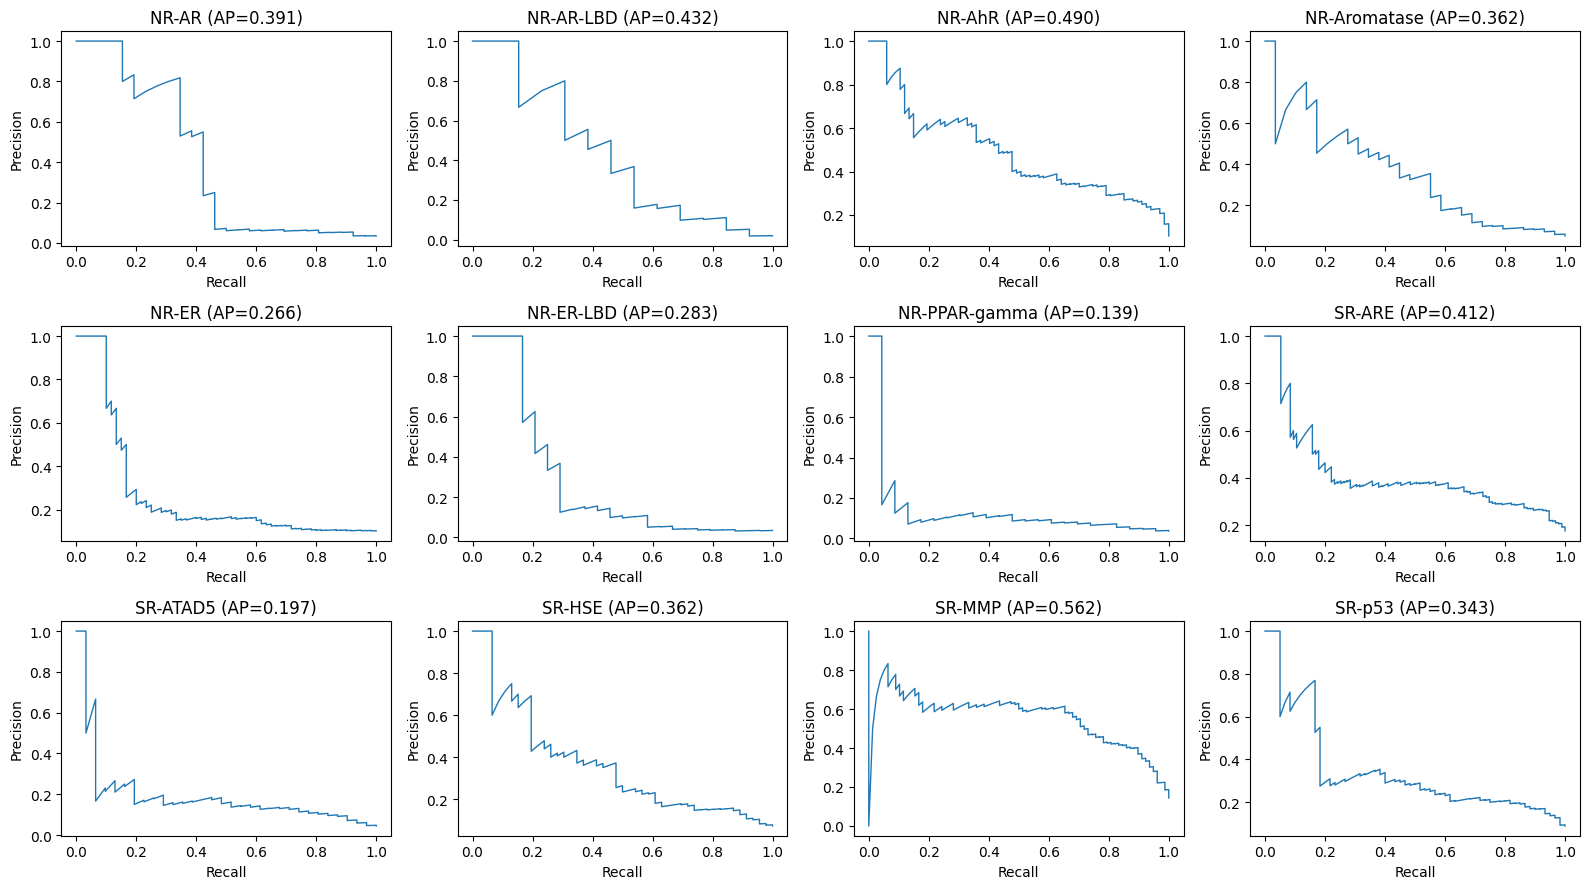

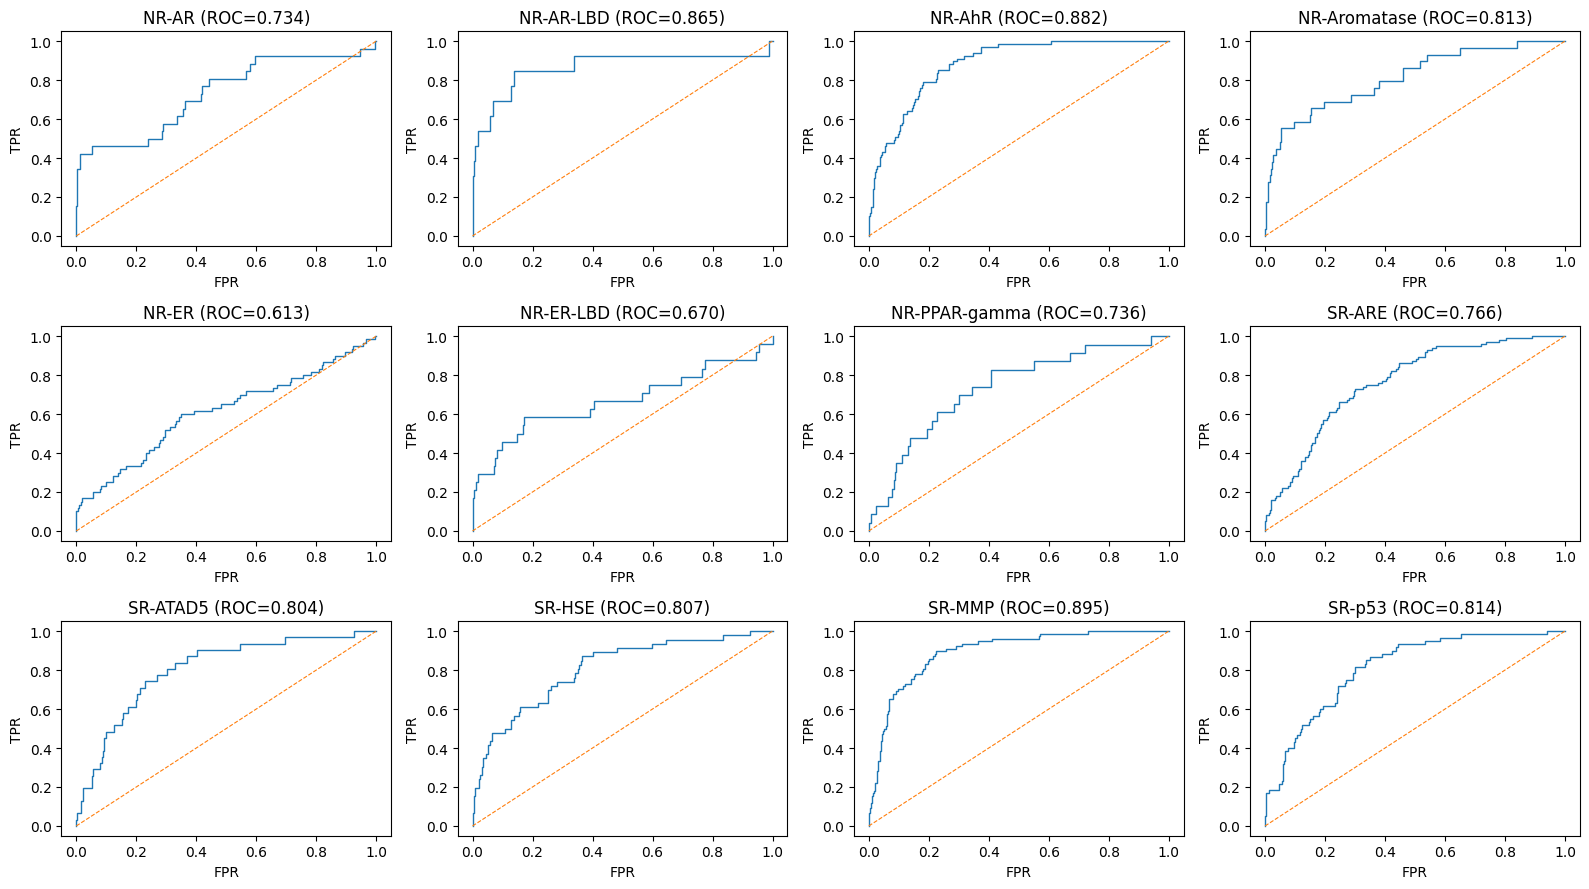

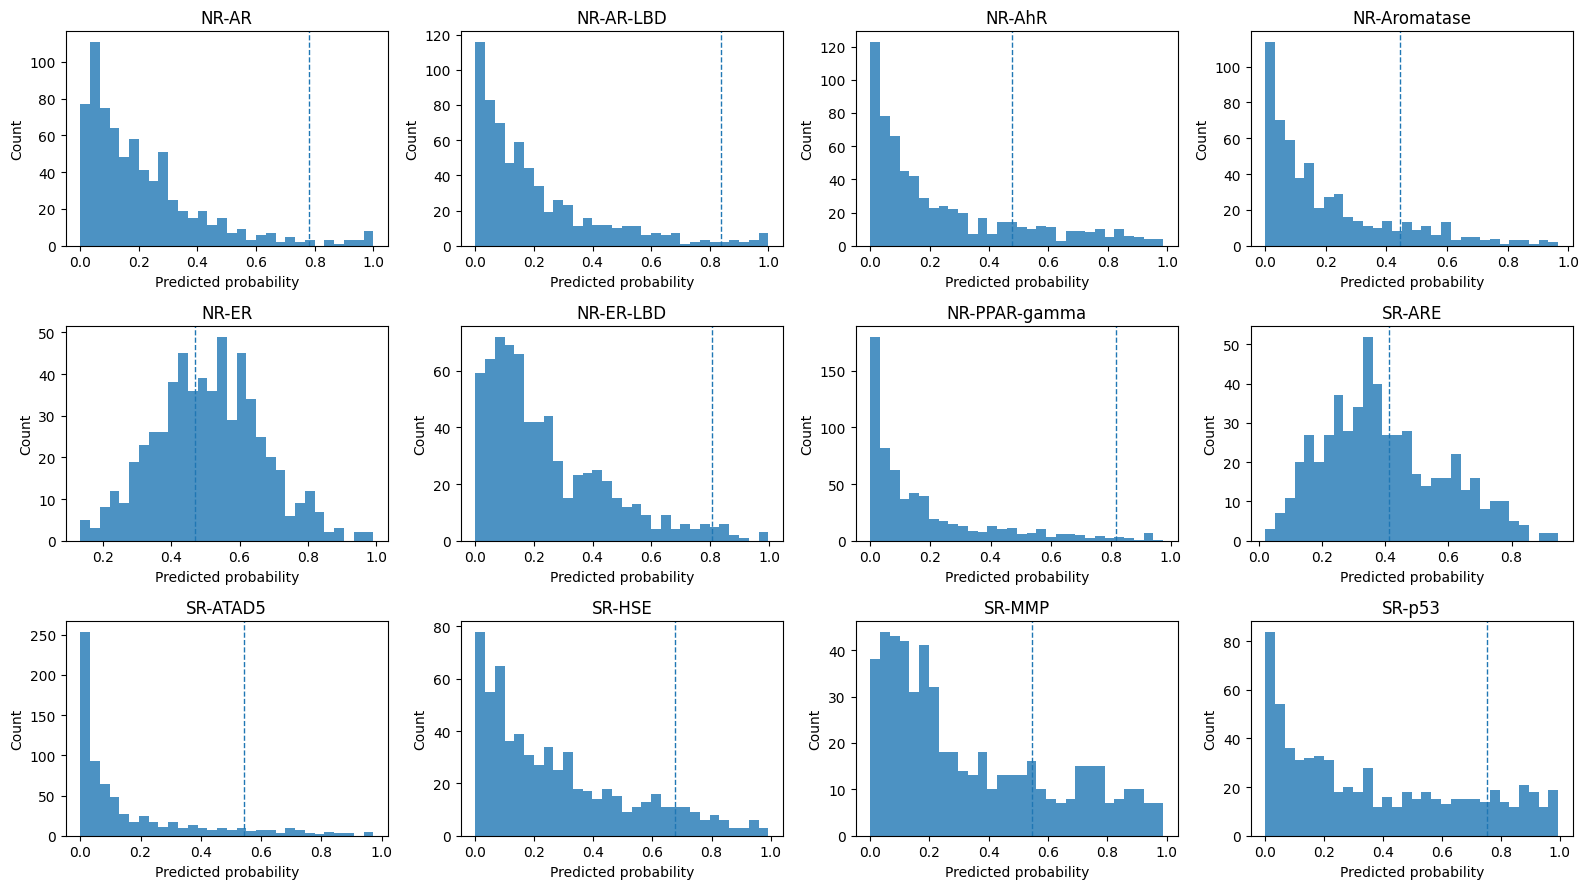

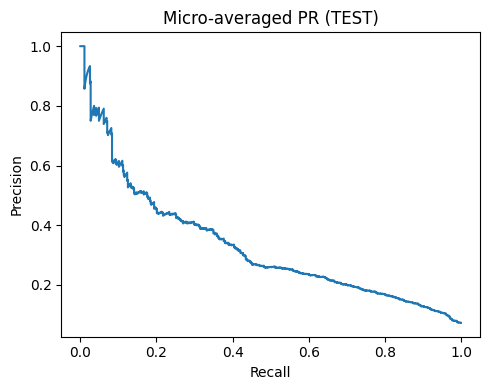

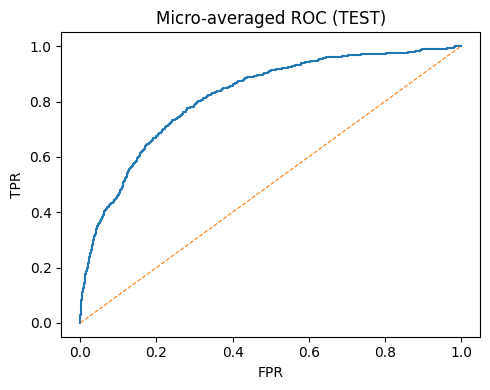

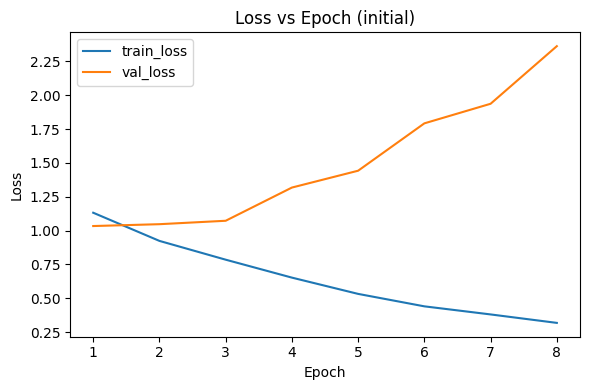

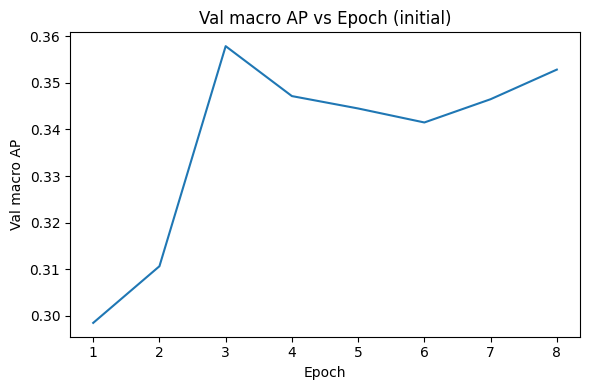

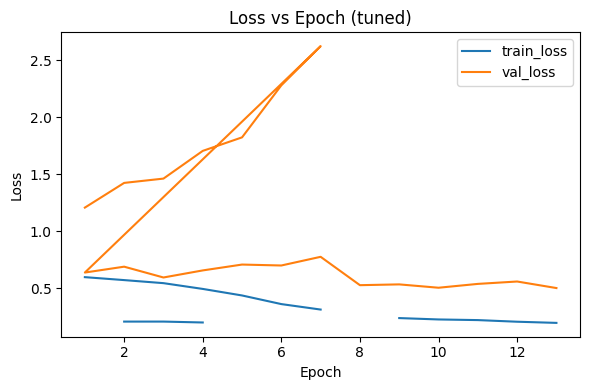

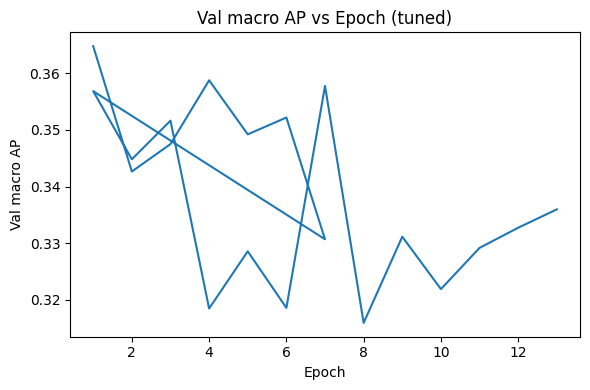


[M7] Saved artifacts to: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chemberta_v4\diag
  - val_per_label.csv / test_per_label.csv
  - test_confusion_at_thresholds.csv
  - test_pr_curves.png / test_roc_curves.png / test_probability_histograms.png
  - test_micro_pr.png / test_micro_roc.png
  - learning_loss_*.png / learning_valmap_*.png (if logs existed)
  - summary.json


In [39]:
# === CELL M7: Diagnostics pack (metrics + figures) ===
import json, math, os, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, roc_curve,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoModel, AutoTokenizer

warnings.filterwarnings("ignore", category=UserWarning)

ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL_DIR = ROOT / "model"
DIAG = ROOT / "diag"
DIAG.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Load config, label names, splits, arrays ----------
CONFIG = json.loads((MODEL_DIR / "config.json").read_text())
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
L = len(label_names)
splits = json.loads((DATA / "splits" / "splits.json").read_text())
val_idx  = np.array(sorted(splits["val"]), dtype=int)
test_idx = np.array(sorted(splits["test"]), dtype=int)

smiles_list = (DATA / "X_smiles.txt").read_text(encoding="utf-8").splitlines()
X_desc = np.load(DESC / "desc_selected.npy").astype(np.float32)
y       = np.load(DATA / "y.npy").astype(np.float32)
y_mask  = np.load(DATA / "y_mask.npy").astype(np.float32)

# thresholds (from M5 final)
thresholds = json.loads((MODEL_DIR / "thresholds.json").read_text())

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR / "tokenizer")

# ---------- Model (inference) ----------
class MeanPooler(nn.Module):
    def forward(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        m = attention_mask.unsqueeze(-1).to(hidden_states.dtype)
        return (hidden_states * m).sum(1) / m.sum(1).clamp(min=1e-6)

class Tox21FusionModel(nn.Module):
    def __init__(self, cfg: dict, n_labels: int):
        super().__init__()
        base = cfg["base_model_name"]
        self.enc_cfg = AutoConfig.from_pretrained(base)
        self.encoder = AutoModel.from_pretrained(base, config=self.enc_cfg)
        if cfg.get("enable_grad_checkpointing", True):
            try: self.encoder.gradient_checkpointing_enable()
            except Exception: pass
        self.pooling = cfg.get("pooling", "mean")
        self.mean_pooler = MeanPooler()
        enc_dim = cfg.get("encoder_embed_dim", getattr(self.enc_cfg, "hidden_size", 768))
        self.desc_mlp = nn.Sequential(
            nn.Linear(cfg["desc_dim_in"], cfg["desc_mlp_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
        )
        self.fusion = nn.Sequential(
            nn.Linear(enc_dim + cfg["desc_mlp_hidden"], cfg["fusion_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
            nn.Linear(cfg["fusion_hidden"], n_labels),
        )
        self.register_buffer("pos_weight", torch.ones(n_labels))

    def forward(self, input_ids, attention_mask, desc):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=False)
        enc_vec = self.mean_pooler(out.last_hidden_state, attention_mask) if self.pooling=="mean" else out.last_hidden_state[:,0]
        desc_vec = self.desc_mlp(desc)
        logits = self.fusion(torch.cat([enc_vec, desc_vec], dim=-1))
        return logits

# Load best checkpoint
model_inf = Tox21FusionModel(CONFIG, n_labels=L).to(device)
pos_weight_np = np.load(MODEL_DIR / "pos_weight.npy")
with torch.no_grad():
    model_inf.pos_weight.copy_(torch.tensor(pos_weight_np, dtype=torch.float32, device=device))

best_ckpt = MODEL_DIR / "best_model_tuned.pt" if (MODEL_DIR / "best_model_tuned.pt").exists() else (MODEL_DIR / "best_model.pt")
state = torch.load(best_ckpt, map_location=device)["model_state"]
model_inf.load_state_dict(state, strict=False)
model_inf.eval()

# ---------- Data plumbing ----------
class _IdxDS(Dataset):
    def __init__(self, idx):
        self.idx = np.array(idx, dtype=int)
    def __len__(self): return len(self.idx)
    def __getitem__(self, k):
        i = int(self.idx[k])
        enc = tokenizer(
            smiles_list[i], max_length=CONFIG["max_length"],
            padding=False, truncation=True, add_special_tokens=True, return_tensors=None
        )
        return {
            "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
            "desc": torch.tensor(X_desc[i], dtype=torch.float32),
            "labels": torch.tensor(y[i], dtype=torch.float32),
            "label_mask": torch.tensor(y_mask[i], dtype=torch.float32),
        }

def _collate_simple(batch):
    pad_id = tokenizer.pad_token_id or 1
    ids_list  = [b["input_ids"] for b in batch]
    attn_list = [b["attention_mask"] for b in batch]
    max_len = max(t.size(0) for t in ids_list)
    B = len(batch)
    ids  = torch.full((B, max_len), pad_id, dtype=torch.long)
    attn = torch.zeros((B, max_len), dtype=torch.long)
    for i, (ii, aa) in enumerate(zip(ids_list, attn_list)):
        Ls = ii.size(0)
        ids[i, :Ls]  = ii
        attn[i, :Ls] = aa
    desc  = torch.stack([b["desc"] for b in batch], dim=0)
    lbls  = torch.stack([b["labels"] for b in batch], dim=0)
    mask  = torch.stack([b["label_mask"] for b in batch], dim=0)
    return {"input_ids": ids, "attention_mask": attn, "desc": desc, "labels": lbls, "label_mask": mask}

def _probs_labels(indices):
    ds = _IdxDS(indices)
    ld = DataLoader(ds, batch_size=64, shuffle=False, num_workers=0, collate_fn=_collate_simple)
    sigm = lambda x: 1.0/(1.0+np.exp(-x))
    logits_all, labels_all, mask_all = [], [], []
    with torch.no_grad():
        for b in ld:
            ids  = b["input_ids"].to(device)
            attn = b["attention_mask"].to(device)
            desc = b["desc"].to(device)
            lbls = b["labels"].cpu().numpy()
            msk  = b["label_mask"].cpu().numpy()
            logits = model_inf(ids, attn, desc).cpu().numpy()
            logits_all.append(logits); labels_all.append(lbls); mask_all.append(msk)
    logits = np.concatenate(logits_all)
    probs  = sigm(logits)
    labels = np.concatenate(labels_all)
    mask   = np.concatenate(mask_all)
    return probs, labels, mask

# ---------- Evaluate on VAL & TEST ----------
val_probs, val_labels, val_mask = _probs_labels(val_idx)
test_probs, test_labels, test_mask = _probs_labels(test_idx)

# ---------- Metrics helpers ----------
def per_label_metrics(probs, labels, mask):
    ap, roc = [], []
    for j in range(L):
        known = mask[:, j] > 0.5
        y_true = labels[known, j]
        p = probs[known, j]
        a = np.nan; r = np.nan
        if y_true.size > 0 and len(np.unique(y_true)) > 1:
            try: a = float(average_precision_score(y_true, p))
            except: a = np.nan
            try: r = float(roc_auc_score(y_true, p))
            except: r = np.nan
        ap.append(a); roc.append(r)
    return np.array(ap), np.array(roc)

def confusion_at_thresholds(probs, labels, mask, thr_dict):
    stats = []
    for j, lbl in enumerate(label_names):
        known = mask[:, j] > 0.5
        y_true = labels[known, j]
        p = probs[known, j]
        t = float(thr_dict[lbl])
        yhat = (p >= t).astype(int)
        tp = int(((yhat==1)&(y_true==1)).sum())
        tn = int(((yhat==0)&(y_true==0)).sum())
        fp = int(((yhat==1)&(y_true==0)).sum())
        fn = int(((yhat==0)&(y_true==1)).sum())
        pr = precision_score(y_true, yhat, zero_division=0)
        rc = recall_score(y_true, yhat, zero_division=0)
        f1 = f1_score(y_true, yhat, zero_division=0)
        prev = float(y_true.mean()) if y_true.size>0 else np.nan
        stats.append({"label": lbl, "threshold": t, "precision": pr, "recall": rc, "f1": f1,
                      "TP": tp, "FP": fp, "TN": tn, "FN": fn, "prevalence": prev})
    return pd.DataFrame(stats)

# ---------- Compute metrics ----------
val_ap, val_roc = per_label_metrics(val_probs, val_labels, val_mask)
test_ap, test_roc = per_label_metrics(test_probs, test_labels, test_mask)
val_macro_ap, val_macro_roc = np.nanmean(val_ap), np.nanmean(val_roc)
test_macro_ap, test_macro_roc = np.nanmean(test_ap), np.nanmean(test_roc)

print("[M7] Macro metrics")
print(f"  VAL  : macro_AP={val_macro_ap:.4f} | macro_ROC={val_macro_roc:.4f}")
print(f"  TEST : macro_AP={test_macro_ap:.4f} | macro_ROC={test_macro_roc:.4f}")

# Save per-label tables
pd.DataFrame({"label": label_names, "AP": val_ap, "ROC": val_roc}).to_csv(DIAG / "val_per_label.csv", index=False)
pd.DataFrame({"label": label_names, "AP": test_ap, "ROC": test_roc}).to_csv(DIAG / "test_per_label.csv", index=False)

# Confusion-style stats at calibrated thresholds (TEST)
df_thr_test = confusion_at_thresholds(test_probs, test_labels, test_mask, thresholds)
df_thr_test.to_csv(DIAG / "test_confusion_at_thresholds.csv", index=False)

# ---------- Plot helpers ----------
def _grid_xy(n):
    # choose a tidy grid for L labels (e.g., 4x3 for 12)
    cols = min(4, L)
    rows = int(math.ceil(L / cols))
    return rows, cols

# PR curves per label (TEST)
rows, cols = _grid_xy(L)
fig_pr, axes_pr = plt.subplots(rows, cols, figsize=(cols*4, rows*3), squeeze=False)
for j, lbl in enumerate(label_names):
    r, c = divmod(j, cols)
    ax = axes_pr[r][c]
    known = test_mask[:, j] > 0.5
    y_true = test_labels[known, j]
    p = test_probs[known, j]
    if y_true.size > 1 and len(np.unique(y_true)) > 1:
        pr, rc, _ = precision_recall_curve(y_true, p)
        ax.plot(rc, pr, lw=1)
        ax.set_title(f"{lbl} (AP={test_ap[j]:.3f})")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
# Hide empty axes
for k in range(L, rows*cols):
    r, c = divmod(k, cols)
    fig_pr.delaxes(axes_pr[r][c])
fig_pr.tight_layout()
fig_pr.savefig(DIAG / "test_pr_curves.png", dpi=200)
plt.show()

# ROC curves per label (TEST)
fig_roc, axes_roc = plt.subplots(rows, cols, figsize=(cols*4, rows*3), squeeze=False)
for j, lbl in enumerate(label_names):
    r, c = divmod(j, cols)
    ax = axes_roc[r][c]
    known = test_mask[:, j] > 0.5
    y_true = test_labels[known, j]
    p = test_probs[known, j]
    if y_true.size > 1 and len(np.unique(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, p)
        ax.plot(fpr, tpr, lw=1)
        ax.plot([0,1],[0,1], linestyle="--", lw=0.8)
        ax.set_title(f"{lbl} (ROC={test_roc[j]:.3f})")
    ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
for k in range(L, rows*cols):
    r, c = divmod(k, cols)
    fig_roc.delaxes(axes_roc[r][c])
fig_roc.tight_layout()
fig_roc.savefig(DIAG / "test_roc_curves.png", dpi=200)
plt.show()

# Probability histograms with threshold (TEST)
fig_hist, axes_hist = plt.subplots(rows, cols, figsize=(cols*4, rows*3), squeeze=False)
for j, lbl in enumerate(label_names):
    r, c = divmod(j, cols)
    ax = axes_hist[r][c]
    known = test_mask[:, j] > 0.5
    p = test_probs[known, j]
    t = float(thresholds[lbl])
    ax.hist(p, bins=30, alpha=0.8)
    ax.axvline(t, linestyle="--", linewidth=1)
    ax.set_title(lbl)
    ax.set_xlabel("Predicted probability"); ax.set_ylabel("Count")
for k in range(L, rows*cols):
    r, c = divmod(k, cols)
    fig_hist.delaxes(axes_hist[r][c])
fig_hist.tight_layout()
fig_hist.savefig(DIAG / "test_probability_histograms.png", dpi=200)
plt.show()

# Micro-averaged PR & ROC (TEST)
known_flat = test_mask.flatten() > 0.5
y_true_flat = test_labels.flatten()[known_flat]
p_flat = test_probs.flatten()[known_flat]

# PR
pr_micro, rc_micro, _ = precision_recall_curve(y_true_flat, p_flat)
fig_micro_pr = plt.figure(figsize=(5,4))
plt.plot(rc_micro, pr_micro)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Micro-averaged PR (TEST)")
fig_micro_pr.tight_layout()
fig_micro_pr.savefig(DIAG / "test_micro_pr.png", dpi=200)
plt.show()

# ROC
fpr_micro, tpr_micro, _ = roc_curve(y_true_flat, p_flat)
fig_micro_roc = plt.figure(figsize=(5,4))
plt.plot(fpr_micro, tpr_micro)
plt.plot([0,1],[0,1], linestyle="--", linewidth=0.8)
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Micro-averaged ROC (TEST)")
fig_micro_roc.tight_layout()
fig_micro_roc.savefig(DIAG / "test_micro_roc.png", dpi=200)
plt.show()

# ---------- Learning curves (if logs exist) ----------
def _plot_log(csv_path, title_suffix):
    if not csv_path.exists():
        return None
    df = pd.read_csv(csv_path)
    fig1 = plt.figure(figsize=(6,4))
    plt.plot(df["epoch"], df["train_loss"], label="train_loss")
    plt.plot(df["epoch"], df["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"Loss vs Epoch ({title_suffix})")
    plt.legend(); fig1.tight_layout()
    fig1.savefig(DIAG / f"learning_loss_{title_suffix}.png", dpi=200)
    plt.show()

    fig2 = plt.figure(figsize=(6,4))
    if "val_macro_ap" in df.columns:
        plt.plot(df["epoch"], df["val_macro_ap"])
        plt.ylabel("Val macro AP")
        plt.title(f"Val macro AP vs Epoch ({title_suffix})")
        plt.xlabel("Epoch")
        fig2.tight_layout()
        fig2.savefig(DIAG / f"learning_valmap_{title_suffix}.png", dpi=200)
        plt.show()
    return True

_ = _plot_log(MODEL_DIR / "train_log.csv", "initial")
_ = _plot_log(MODEL_DIR / "train_log_tuned.csv", "tuned")

# ---------- Save a compact metrics summary ----------
summary = {
    "val_macro_AP": float(val_macro_ap),
    "val_macro_ROC": float(val_macro_roc),
    "test_macro_AP": float(test_macro_ap),
    "test_macro_ROC": float(test_macro_roc),
    "best_checkpoint": best_ckpt.name,
}
(Path(DIAG / "summary.json")).write_text(json.dumps(summary, indent=2), encoding="utf-8")

print("\n[M7] Saved artifacts to:", DIAG.resolve())
print("  - val_per_label.csv / test_per_label.csv")
print("  - test_confusion_at_thresholds.csv")
print("  - test_pr_curves.png / test_roc_curves.png / test_probability_histograms.png")
print("  - test_micro_pr.png / test_micro_roc.png")
print("  - learning_loss_*.png / learning_valmap_*.png (if logs existed)")
print("  - summary.json")
